In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'

In [11]:
animalnames = os.listdir(os.path.join('S:\\\\Sorts','DualRecording'))
animalnames.remove('BS_33')
animalnames.remove('BS_67')#Only days 15 onward removed
animalnames.remove('BS_73')
animalnames.remove('BS_78')

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
#animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
animals['BS_70'].reversal = 11
animals['BS_72'].reversal = 6
animals['BS_83'].reversal = 20
animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
animals['BS_95'].reversal = 8

In [12]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

plot=False
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
for animalidx,animal in enumerate(animals):
    
    condname = 'd\' ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])

        ax.set_title(animal)
if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Middle cutoff.png'),transparent=False,facecolor="white")

In [4]:
directory = 'D:\\Analysis_Cache'

numbersessions = 0
numberdisqlen = 0
numberdisqISI = 0
numberdisqFR = 0
numAC = 0
numM2 = 0
numTrim = 0

sessions = os.listdir(directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    numbersessions += 1
    numberdisqlen += len(sessionfile.disqualified.NumTrials)
    numberdisqISI += len(sessionfile.disqualified.ISI)
    numberdisqFR += len(sessionfile.disqualified.FRthresh)

    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
    else:
        pass
    
    if hasattr(sessionfile,'trim'):
        numTrim += 1

print(str(numbersessions)+' sessions')
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))
print('Trim     : ' + str(numTrim))
print('Disq Len : ' + str(numberdisqlen))
print('Disq ISI : ' + str(numberdisqISI))
print('Disq FR  : ' + str(numberdisqFR))
print(sessionfile.meta)

344 sessions
AC       : 2170
M2       : 2688
Trim     : 344
Disq Len : 544
Disq ISI : 33
Disq FR  : 74
namespace(animal='BS_95', arraystart=0, behavior='naive', condition='postreversal naive', date='3/1/2022', day_of_recording=6, day_of_reversal=3, day_of_training=11, depth=817, directory='D:\\DualRecording\\BS_95\\BS_95 6\\M2\\', files=['March 1 2022 Dual BS_95_6001', 'March 1 2022 Dual BS_95_6002', 'March 1 2022 Dual BS_95_6003'], fs=30000, length_in_minutes=18.683240555555553, length_in_samples=33629833.0, length_in_seconds=1120.9944333333333, length_in_trials=332, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=8946, region='M2', task='reversal', tonelength=0.1, triallength=2.5)


In [4]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

#Examples
#animalstouse = ['BS_33','BS_49','BS_103']
#cluststouse = [26,63,82,147,193]
#ylimstouse = [0,30,60]#Always 3
#ticksize = 7.5

animalstouse = ['BS_56','BS_78','BS_113','BS_49','BS_42','BS_70']
cluststouse = [19,44,4,156,10,26]
ytickstouse = [0,15,30]#Always 3
ticksize = 7.5

starttime = -0.7
endtime = 2.7
numbins = 100 + 1

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)
    
for session in tqdm(sessions):
    #break
    try:
        sessionfile = ilep.loadSessionCached(directory,session)
        if not sessionfile.meta.animal in animalstouse:
            continue
        
        #if not sessionfile.meta.task == 'switch':
        #    continue
        
        neurons = sessionfile.clusters.good
        
        ##########################################################################################################################
        #laserON = sessionfile.trials.laser_stimulation
        #laserOFF = np.logical_not(laserON)
        GoResponse = sessionfile.trials.go
        NogoResponse = np.logical_not(GoResponse)
        TargetTone = sessionfile.trials.target
        NontargetTone = np.logical_not(TargetTone)
        
        Hits = np.logical_and(TargetTone,GoResponse)
        Misses = np.logical_and(TargetTone,NogoResponse)
        FAlarms = np.logical_and(NontargetTone,GoResponse)
        CRejects = np.logical_and(NontargetTone,NogoResponse)
        Correct = np.logical_or(Hits,CRejects)
        Incorrect = np.logical_or(Misses,FAlarms)

        ##########################################################################################################################
        
        for clust in neurons:
            if not clust in cluststouse:
                continue
        
            conditions = []        
            #Condition A -- Target Trials
            condition = SimpleNamespace()
            target_trials = sessionfile.trials.target
            target_trials = np.array(np.where(target_trials)[0])
            target_trials = target_trials[np.isin(target_trials,sessionfile.trim[clust].trimmed_trials)]
            condition.trials = target_trials
            condition.label = 'target_trials'
            condition.color = TARGET_COLOR
            conditions.append(condition)
            #Condition B -- Nontarget Trials
            condition = SimpleNamespace()
            nontarget_trials = np.logical_not(sessionfile.trials.target)
            nontarget_trials = np.array(np.where(nontarget_trials)[0])
            nontarget_trials = nontarget_trials[np.isin(nontarget_trials,sessionfile.trim[clust].trimmed_trials)]
            condition.trials = nontarget_trials
            condition.label = 'nontarget_trials'
            condition.color = NONTARGET_COLOR
            conditions.append(condition)
            
            
            if sessionfile.meta.task == 'switch':
                targetcutoff = np.less(target_trials,sessionfile.meta.first_reversal_trial)
                targetcutoff = np.sum(targetcutoff)+0.5
                
                nontargetcutoff = np.less(nontarget_trials,sessionfile.meta.first_reversal_trial)
                nontargetcutoff = np.sum(nontargetcutoff)+0.5

            totaltrials = 0
            for cond in conditions:
                totaltrials += len(cond.trials)
                    
            plt.close('all')
            fig = plt.figure(figsize=(9,12.5))
            gs = fig.add_gridspec(3,2,height_ratios=[4,1,1],hspace=0.2,wspace=0.5)#0.1)
                
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1],sharex=ax1)#FRs
            ax4 = plt.subplot(gs[1,1],sharex=ax1,sharey=ax2)#Percent Go
                        
            ax1.spines['bottom'].set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax1.get_xaxis().set_visible(False)
            ax3.get_xaxis().set_visible(False)
            
            #Caching search -- Unit
            idx = np.equal(sessionfile.spikes.clusters,clust)
            totaltimes = sessionfile.spikes.times[idx]
            
            FRpertrial = []
            #Overall Nonstationarity
            for trial in range(sessionfile.meta.length_in_trials):
                trialstart = sessionfile.trials.starts[trial]
                trialend = sessionfile.trials.ends[trial]
                idxtone = np.logical_and(   np.greater(totaltimes,trialstart) , np.less(totaltimes,trialend)  )
                timestone = totaltimes[idxtone]
                trialtime = (trialend-trialstart) / sessionfile.meta.fs
                FRpertrial.append(len(timestone) / trialtime)
            
            for cond in conditions:         
                cond.latency = []
                cond.firingrates = []
                cond.timestoplot = []
                cond.trialstoplot = []
                cond.responsetimestoplot = []
                cond.responsetrialstoplot = []
                cond.peristimulustimes = []
                cond.onsetmodulation = np.nan
                cond.offsetmodulation = np.nan
                cond.pc = np.nan
                cond.dp = np.nan
                
                cond.firingbins100 = []
                cond.firingbins200 = []
                
                pretonebin1 = []
                pretonebin2 = []
                tonebin = []
                posttonebin = []
                
                #Calculate Behavior Stats
                temparray = np.zeros(sessionfile.meta.length_in_trials)
                temparray[cond.trials] = np.ones(len(cond.trials))
                condhits = np.sum(np.logical_and(temparray,Hits))
                condmisses = np.sum(np.logical_and(temparray,Misses))
                condfalarms = np.sum(np.logical_and(temparray,FAlarms))
                condcrejects = np.sum(np.logical_and(temparray,CRejects))
                
                try:
                    cond.pc = (condhits+condmisses) / (condhits+condmisses+condfalarms+condcrejects)
                except Exception:
                    pass
                try:
                    cond.dp = norm.ppf((condhits+1)/(condhits+condmisses+2)) - norm.ppf((condfalarms+1)/(condfalarms+condcrejects+2))
                except Exception:
                    pass
                
                for trialidx in range(len(cond.trials)):
                    trial = cond.trials[trialidx]
                    trialstart = sessionfile.trials.starts[trial]
                    
                    #Caching search -- Condition
                    idx = np.logical_and(      np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs)     )
                    times = totaltimes[idx]
                    
                    #PSTH times
                    cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
                    
                    #Response times
                    if (sessionfile.trials.go[trial]):
                        cond.responsetimestoplot.append((sessionfile.trials.response[trial]-trialstart)/sessionfile.meta.fs*1000)
                        cond.responsetrialstoplot.append(trialidx+1)
                    
                    #Each spike time to plot
                    for spike in ((times-trialstart)/sessionfile.meta.fs*1000):
                        cond.timestoplot.append(spike)
                        cond.trialstoplot.append(trialidx+1)
                    
                    #Caching search -- Pre-tone period (1)
                    binstart = trialstart-0.2*sessionfile.meta.fs
                    binend = trialstart-0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin1.append(len(timestone))
                    
                    #Caching search -- Pre-tone period (2)
                    binstart = trialstart-0.1*sessionfile.meta.fs
                    binend = trialstart+0*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    pretonebin2.append(len(timestone))
                    
                    #Caching search -- Tone Period
                    binstart = trialstart+0*sessionfile.meta.fs
                    binend = trialstart+0.1*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    tonebin.append(len(timestone))
                    cond.firingbins100.append(len(timestone))
                    tempvar = (len(timestone))
                    #Latency and firing rate
                    if len(timestone)>0:
                        cond.latency.append( (np.min(timestone)-trialstart)/sessionfile.meta.fs*1000)
                    else:
                        cond.latency.append(np.nan)
                    cond.firingrates.append(len(timestone) / (0.1))
                    
                    #Caching search -- Post-tone period
                    binstart = trialstart+0.1*sessionfile.meta.fs
                    binend = trialstart+0.2*sessionfile.meta.fs
                    idxtone = np.logical_and(   np.greater(totaltimes,binstart) , np.less(totaltimes,binend)  )
                    timestone = totaltimes[idxtone]
                    posttonebin.append(len(timestone))
                    cond.firingbins200.append(len(timestone)+tempvar)
                    
                    #Calculate bootstrapped firing rate modulation
                    pretonebins = np.concatenate((pretonebin1,pretonebin2))
                    numtrials = len(tonebin)
                    FRmodonset = []
                    FRmodoffset = []
                    for sample in range(100):
                        baseline = np.mean(np.random.choice(pretonebins,size=int(0.9*numtrials),replace=True))
                        if baseline == 0:
                            baseline = 0.01
                        onset = np.mean(np.random.choice(tonebin,size=int(0.9*numtrials),replace=True))
                        offset = np.mean(np.random.choice(posttonebin,size=int(0.9*numtrials),replace=True))
                        FRmodonset.append((onset-baseline))
                        FRmodoffset.append((offset-baseline))
                    cond.onsetmodulation = np.mean(FRmodonset)*10 #Scaling factor from 100ms bin to firing rate (1s)
                    cond.offsetmodulation = np.mean(FRmodoffset)*10
                        
                        
            #############################################---PLOTTING---#############################################
                
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[0]]:
                ax1.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=ticksize,c=cond.color,marker=custommarker.vertices)
                #ax1.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax1.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax1.set_ylim(ylims1)
            if sessionfile.meta.task == 'switch':
                xlims = ax1.get_xlim()
                ax1.plot(xlims,[targetcutoff,targetcutoff],linestyle='--',lw=1,color='k')
                ax1.set_xlim(xlims)
            ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax1.set_ylabel('Trial')
            
            #Plot Rasters
            #ylims1 = [1,totaltrials]
            offset = 0
            tickmeans = []
            ticklabels = []
            numtrials = 0
            for cond in [conditions[1]]:
                ax3.scatter(cond.timestoplot,np.array(cond.trialstoplot)+offset,s=ticksize,c=cond.color,marker=custommarker.vertices)
                #ax3.scatter(cond.responsetimestoplot,np.array(cond.responsetrialstoplot)+offset,s=7.5,c='black')
                tickmeans.append(0.5*len(cond.trials)+offset)
                #ax3.fill_between([starttime*1000,endtime*1000],[offset,offset],[offset+len(cond.trials),offset+len(cond.trials)],fc=cond.color,alpha=trans,zorder=-10)
                offset += len(cond.trials)
                ticklabels.append(cond.label+'\n Onset: '+str(np.round(cond.onsetmodulation,2))+'\n Offset: '+str(np.round(cond.offsetmodulation,2)))
                numtrials += len(cond.trials)
            ylims1 = [1,numtrials]
            #Label Conditions
            #ticks = [1, np.round(len(trialidxs)/20)*10 ,len(trialidxs)]
            ax3.set_ylim(ylims1)
            if sessionfile.meta.task == 'switch':
                xlims = ax3.get_xlim()
                ax3.plot(xlims,[nontargetcutoff,nontargetcutoff],linestyle='--',lw=1,color='k')
                ax3.set_xlim(xlims)
            ax3.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            ax3.set_ylabel('Trial')
            
            #Plot PSTHs
            ind = 0
            for cond in [conditions[0]]:
                try:
                    X,FR = ilep.getPSTH(sessionfile,clust,cond,PSTHstart = starttime,PSTHend = endtime,bw=0.0125)
                    ax2.plot(X,FR,c=cond.color,lw=2)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            ax2.set_ylim([ytickstouse[0],ytickstouse[2]])
            ax2.set_yticks(ytickstouse)
            
            #Plot PSTHs
            ind = 0
            for cond in [conditions[1]]:
                try:
                    X,FR = ilep.getPSTH(sessionfile,clust,cond,PSTHstart = starttime,PSTHend = endtime,bw=0.0125)
                    ax4.plot(X,FR,c=cond.color,lw=2)
                except Exception as e:
                    print('PSTHs: '+str(e))
                ind = ind + 1
            ax4.set_ylim([ytickstouse[0],ytickstouse[2]])
            ax4.set_yticks(ytickstouse)
                
            ax2.set_xticks([0,1000,2000])
            ax2.set_xticklabels([0,1,2])
            ax4.set_xticks([0,1000,2000])
            ax4.set_xticklabels([0,1,2])

            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Spikes per second')
            ax2.set_xlabel('Time (s)')
            
            ylims4 = ax4.get_ylim()
            ax4.fill_between([0,100],[ylims4[1],ylims4[1]],color='grey',alpha=trans)
            ax4.set_ylabel('Spikes per second')
            ax4.set_xlabel('Time (s)')
            
            ax1.set_xlim([-500,2500])
            
            task = 'ERROR'
            if sessionfile.meta.task == 'switch':
                task = 'switch'
            elif sessionfile.meta.condition == 'prereversal expert':
                task = 'late prereversal'
            elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training <= 3:
                task = 'early prereversal'
            elif sessionfile.meta.condition == 'prereversal naive':
                task = 'middle prereversal'
            elif sessionfile.meta.condition == 'postreversal expert':
                task = 'late postreversal'
            elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_reversal <= 3:
                task = 'early postreversal'
            elif sessionfile.meta.condition == 'postreversal naive':
                task = 'middle postreversal'
            #fig.savefig(os.path.join('D:\\\\Figures','Blake',task,'PNGs',session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\Figures','Blake',task,'PDFs',session + ' cluster ' + str(clust) + ' TargNontarg.pdf'),transparent=False,facecolor="white")
            fig.savefig(os.path.join('D:\\\\Figures','Blake2','PNGs',session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
            fig.savefig(os.path.join('D:\\\\Figures','Blake2','PDFs',session + ' cluster ' + str(clust) + ' TargNontarg.pdf'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)
        pass

  0%|          | 0/344 [00:00<?, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 15/344 [00:04<01:44,  3.13it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 15/344 [00:09<03:30,  1.56it/s]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000262EFA3BAF0> (for post_execute):


KeyboardInterrupt: 

 31%|███       | 105/344 [00:00<00:00, 323.07it/s]

early postreversal
BS_42_2_AC.pickle
early postreversal
BS_42_3_AC.pickle


100%|██████████| 344/344 [00:02<00:00, 121.93it/s]


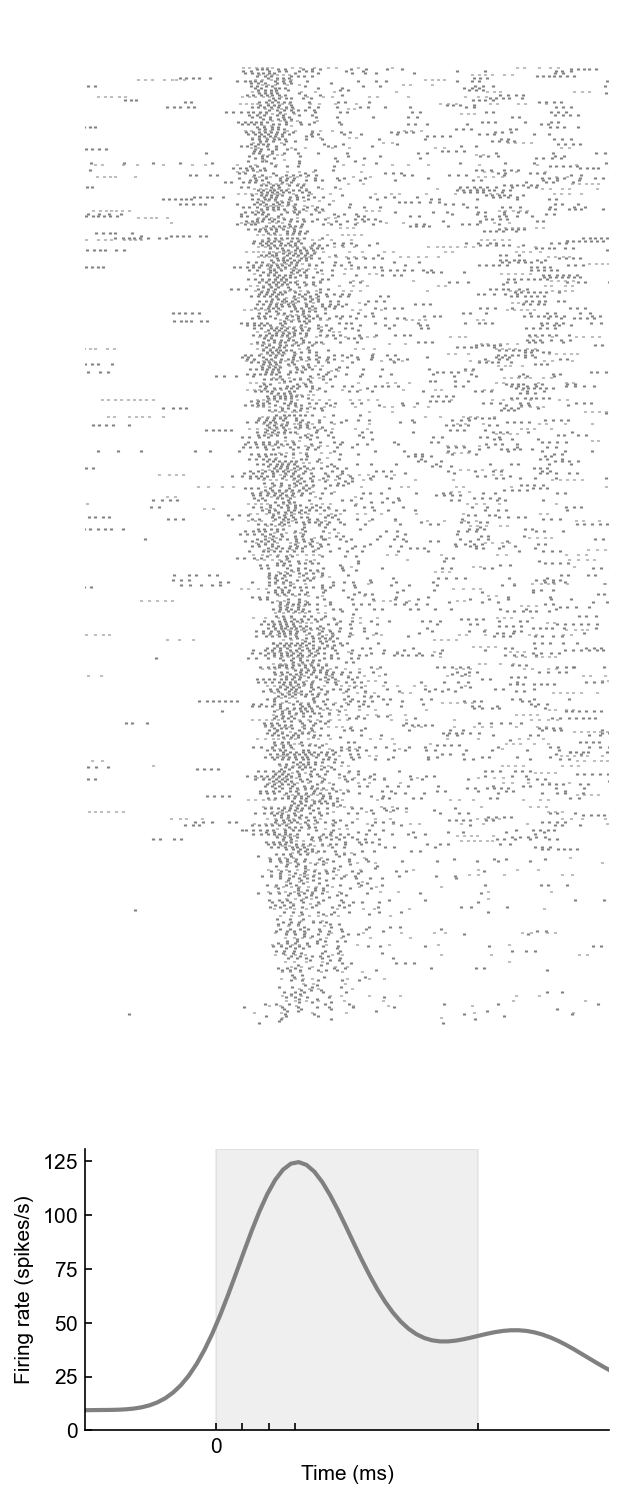

In [15]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

#Examples
#animalstouse = ['BS_33','BS_49','BS_103']
#cluststouse = [26,63,82,147,193]
#ylimstouse = [0,30,60]#Always 3
#ticksize = 7.5

#animalstouse = ['BS_56','BS_78','BS_113','BS_49','BS_42','BS_70']
#cluststouse = [19,44,4,156,10,26]
#ytickstouse = [0,15,30]#Always 3
#ticksize = 7.5

sessionstouse = ['BS_95_1_AC.pickle','BS_95_1_M2.pickle','BS_85_9_AC.pickle','BS_85_9_M2.pickle']
#animalstouse = ['BS_33','BS_108']
cluststouse = [104,215,107,27]

starttime = -500
endtime = 2500
units = 'ms'

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

n = 0
    
for session in tqdm(sessions):
    #if not session in sessionstouse:
        #continue
    #break
    
    try:
        sessionfile = ilep.loadSessionCached(directory,session)

        for clust in sessionfile.clusters.good:            
            #if not clust in cluststouse:
                #continue
                
            if sessionfile.responsiveness[clust]['all_trials'].FRmodulation < 100:
                continue
        
            conditions = ilep.getAllConditions(sessionfile,clust)
                
            plt.close('all')
            fig = plt.figure(figsize=(4.5,12.5))
            gs = fig.add_gridspec(2,1,height_ratios=[4,1],hspace=0.0125)#,wspace=0.5)#0.1)
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            
            ax1.spines['bottom'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.get_xaxis().set_visible(False)
            ax1.get_yaxis().set_visible(False)
            
            color=NCR_CR_cmap(sessionfile.responsiveness[clust]['all_trials'].FRmodulation/4)
            
            #Plot Rasters
            try:
                times = ilep.getRaster(sessionfile,clust,conditions['all_trials'],startbuffer=0.5,units=units)
                #print(times)
                ax1.eventplot(times,color=color)
            except Exception as e:
                print('Rasters: '+str(e))
            
            #ticks = list(ax1.get_yticks())
            #ticks.append(1)
            #ticks.append(len(conditions['all_trials'].trials))
            #ticks = np.unique(ticks)
            #ax1.set_yticks(ticks)
            
            #ylims1 = np.array([0,len(conditions['all_trials'].trials)])+1
            #ax1.set_ylim(ylims1)
            
            if sessionfile.meta.task == 'switch':
                reversaltrial = np.less(conditions['all_trials'].trials,sessionfile.meta.first_reversal_trial)
                reversaltrial = np.sum(reversaltrial)+0.5
                
                xlims = ax1.get_xlim()
                ax1.plot(xlims,[reversaltrial,reversaltrial],linestyle='--',lw=1,color='k')
                ax1.set_xlim(xlims)
                
            #ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            #ax1.set_ylabel('Trial')
            
            #Plot PSTHs
            try:
                X,FR = ilep.getPSTH(sessionfile,clust,conditions['all_trials'], PSTHstart = starttime, PSTHend = endtime, units = 'ms', bw=0.02)
                ax2.plot(X,FR,color=color,lw=2)
            except Exception as e:
                print('PSTHs: '+str(e)) 
            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Firing rate (spikes/s)')
            ax2.set_xlabel('Time (ms)')
            
            ax2.set_ylim([0,ylims2[1]])
            
            ax2.set_xticks([-500,0,500,1000,1500,2000,2500])
            ax2.set_xticklabels(['-500','0','500','1000','1500','2000','2500'])
            
            ax1.set_xlim([-50,150])
            ax2.set_xlim([-50,150])
            ax2.set_xticks([0,10,20,30,100])

            task = 'ERROR'
            if sessionfile.meta.task == 'switch':
                task = 'switch'
            if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
                task = 'early prereversal'
            elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
                task = 'middle prereversal'
            elif sessionfile.meta.condition == 'prereversal expert':
                task = 'late prereversal'
            elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
                task = 'early postreversal'
            elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
                task = 'middle postreversal'
            elif sessionfile.meta.condition == 'postreversal expert':
                task = 'late postreversal'
                
            print(task)
            print(session)
            n += 1
            
            fig.savefig(os.path.join('D:\\\\TempFigures','Big Cell '+str(n)+'.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PNGs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PDFs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.pdf'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PNGs',session + ' cluster ' + str(clust) + '.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PDFs',session + ' cluster ' + str(clust) + '.pdf'),transparent=False,facecolor="white")
    except Exception as e:
        raise

  9%|▉         | 35/398 [00:00<00:01, 346.91it/s]

ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_AC.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle


  9%|▉         | 35/398 [00:16<00:01, 346.91it/s]

ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle
ERROR
BS_40_10_M2.pickle


 16%|█▌        | 62/398 [00:34<03:46,  1.49it/s] 

ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle
ERROR
BS_40_11_M2.pickle


 16%|█▌        | 64/398 [00:56<06:48,  1.22s/it]

ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle
ERROR
BS_40_12_AC.pickle


 16%|█▋        | 65/398 [01:06<08:25,  1.52s/it]

ERROR
BS_40_12_AC.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_13_M2.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle


 16%|█▋        | 65/398 [01:16<08:25,  1.52s/it]

ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_AC.pickle


 17%|█▋        | 69/398 [01:32<13:02,  2.38s/it]

ERROR
BS_40_14_AC.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle
ERROR
BS_40_14_M2.pickle


 18%|█▊        | 70/398 [01:52<18:36,  3.40s/it]

ERROR
BS_40_14_M2.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_AC.pickle


 18%|█▊        | 71/398 [02:01<20:41,  3.80s/it]

ERROR
BS_40_15_AC.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_15_M2.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_AC.pickle
ERROR
BS_40_16_M2.pickle
ERROR
BS_40_16_M2.pickle
ERROR
BS_40_16_M2.pickle
ERROR
BS_40_16_M2.pickle
ERROR
BS_40_16_M2.pickle


 18%|█▊        | 71/398 [02:19<20:41,  3.80s/it]

ERROR
BS_40_18_AC.pickle
ERROR
BS_40_18_AC.pickle
ERROR
BS_40_18_AC.pickle
ERROR
BS_40_18_AC.pickle
ERROR
BS_40_18_AC.pickle


 19%|█▉        | 75/398 [02:22<23:05,  4.29s/it]

ERROR
BS_40_18_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle
ERROR
BS_40_19_AC.pickle


 19%|█▉        | 76/398 [02:29<24:19,  4.53s/it]

ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_21_AC.pickle
ERROR
BS_40_22_AC.pickle
ERROR
BS_40_22_AC.pickle
ERROR
BS_40_22_AC.pickle
ERROR
BS_40_22_AC.pickle
ERROR
BS_40_22_AC.pickle


 20%|█▉        | 78/398 [02:41<26:00,  4.88s/it]

ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_AC

 20%|█▉        | 79/398 [03:07<40:32,  7.63s/it]

ERROR
BS_40_2_AC.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle
ERROR
BS_40_2_M2.pickle


 20%|██        | 80/398 [03:31<54:35, 10.30s/it]

ERROR
BS_40_2_M2.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle
ERROR
BS_40_3_AC.pickle


 20%|██        | 81/398 [03:42<55:38, 10.53s/it]

ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle
ERROR
BS_40_3_M2.pickle


 21%|██        | 82/398 [03:53<55:45, 10.59s/it]

ERROR
BS_40_3_M2.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle
ERROR
BS_40_4_AC.pickle


 21%|██        | 83/398 [03:58<48:22,  9.21s/it]

ERROR
BS_40_4_AC.pickle
ERROR
BS_40_5_AC.pickle
ERROR
BS_40_5_AC.pickle
ERROR
BS_40_5_AC.pickle
ERROR
BS_40_5_AC.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle


 21%|██        | 83/398 [04:12<48:22,  9.21s/it]

ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle
ERROR
BS_40_5_M2.pickle


 21%|██▏       | 85/398 [04:19<50:39,  9.71s/it]

ERROR
BS_40_5_M2.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle
ERROR
BS_40_6_AC.pickle


 22%|██▏       | 86/398 [04:26<47:24,  9.12s/it]

ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_6_M2.pickle
ERROR
BS_40_7_AC.pickle
ERROR
BS_40_7_AC.pickle
ERROR
BS_40_7_AC.pickle
ERROR
BS_40_7_AC.pickle


 22%|██▏       | 88/398 [04:42<44:43,  8.66s/it]

ERROR
BS_40_7_M2.pickle
ERROR
BS_40_7_M2.pickle


 22%|██▏       | 89/398 [04:43<36:55,  7.17s/it]

ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle
ERROR
BS_40_8_AC.pickle


100%|██████████| 398/398 [04:53<00:00,  1.35it/s]


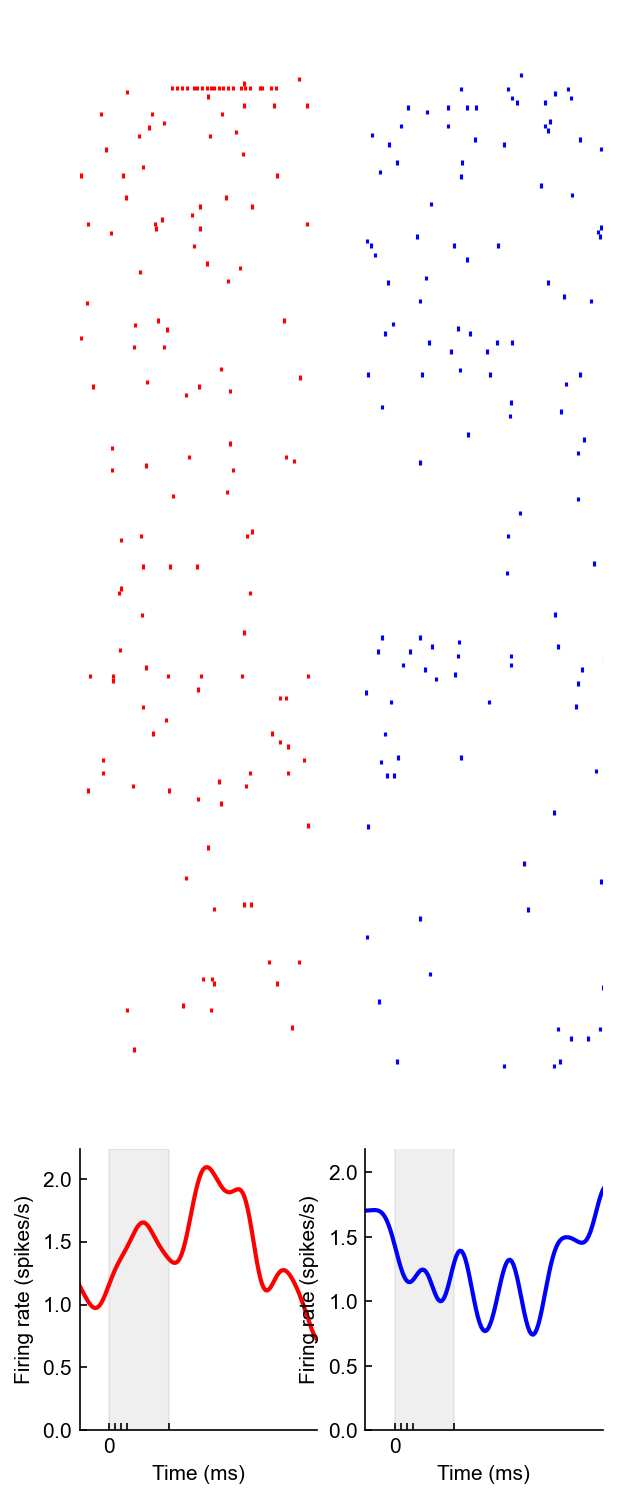

In [7]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

#Examples
#animalstouse = ['BS_33','BS_49','BS_103']
#cluststouse = [26,63,82,147,193]
#ylimstouse = [0,30,60]#Always 3
#ticksize = 7.5

#animalstouse = ['BS_56','BS_78','BS_113','BS_49','BS_42','BS_70']
#cluststouse = [19,44,4,156,10,26]
#ytickstouse = [0,15,30]#Always 3
#ticksize = 7.5

#sessionstouse = ['BS_95_1_AC.pickle','BS_95_1_M2.pickle','BS_85_9_AC.pickle','BS_85_9_M2.pickle']
animalstouse = ['BS_40']
#cluststouse = [104,215,107,27]

starttime = -500
endtime = 2500
units = 'ms'

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

n = 0
    
for session in tqdm(os.listdir(act_directory)):
    #if not session in sessionstouse:
        #continue
    #break
    
    try:
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
        if not sessionfile.meta.animal in animalstouse:
            continue

        for clust in sessionfile.clusters.good:            
            #if not clust in cluststouse:
                #continue
        
            conditions = ilep.getAllConditions(sessionfile,clust)
                
            plt.close('all')
            fig = plt.figure(figsize=(4.5,12.5))
            gs = fig.add_gridspec(2,2,height_ratios=[4,1],hspace=0.0125)#,wspace=0.5)#0.1)
            ax1 = plt.subplot(gs[0,0])#Raster
            ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            ax3 = plt.subplot(gs[0,1],sharex=ax1)#Raster
            ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
            
            ax1.spines['bottom'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.get_xaxis().set_visible(False)
            ax1.get_yaxis().set_visible(False)
            ax3.spines['bottom'].set_visible(False)
            ax3.spines['left'].set_visible(False)
            ax3.get_xaxis().set_visible(False)
            ax3.get_yaxis().set_visible(False)
            
            color=NCR_CR_cmap(sessionfile.responsiveness[clust]['all_trials'].FRmodulation/4)
            
            #Plot Rasters
            try:
                times = ilep.getRaster(sessionfile,clust,conditions['target_tone'],startbuffer=0.5,units=units)
                #print(times)
                ax1.eventplot(times,color='red')
            except Exception as e:
                print('Rasters: '+str(e))
                
            try:
                times2 = ilep.getRaster(sessionfile,clust,conditions['nontarget_tone'],startbuffer=0.5,units=units)
                #print(times)
                ax3.eventplot(times2,color='blue')
            except Exception as e:
                print('Rasters: '+str(e))
            
            #ticks = list(ax1.get_yticks())
            #ticks.append(1)
            #ticks.append(len(conditions['all_trials'].trials))
            #ticks = np.unique(ticks)
            #ax1.set_yticks(ticks)
            
            #ylims1 = np.array([0,len(conditions['all_trials'].trials)])+1
            #ax1.set_ylim(ylims1)
            
            if sessionfile.meta.task == 'switch':
                reversaltrial = np.less(conditions['all_trials'].trials,sessionfile.meta.first_reversal_trial)
                reversaltrial = np.sum(reversaltrial)+0.5
                
                xlims = ax1.get_xlim()
                ax1.plot(xlims,[reversaltrial,reversaltrial],linestyle='--',lw=1,color='k')
                ax1.set_xlim(xlims)
                ax3.plot(xlims,[reversaltrial,reversaltrial],linestyle='--',lw=1,color='k')
                ax3.set_xlim(xlims)
                
            #ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
            #ax1.set_ylabel('Trial')
            
            #Plot PSTHs
            try:
                X,FR = ilep.getPSTH(sessionfile,clust,conditions['target_tone'], PSTHstart = starttime, PSTHend = endtime, units = 'ms', bw=0.02)
                ax2.plot(X,FR,color='red',lw=2)
            except Exception as e:
                print('PSTHs: '+str(e)) 
            ylims2 = ax2.get_ylim()
            ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax2.set_ylabel('Firing rate (spikes/s)')
            ax2.set_xlabel('Time (ms)')
            
            try:
                X2,FR2 = ilep.getPSTH(sessionfile,clust,conditions['nontarget_tone'], PSTHstart = starttime, PSTHend = endtime, units = 'ms', bw=0.02)
                ax4.plot(X2,FR2,color='blue',lw=2)
            except Exception as e:
                print('PSTHs: '+str(e)) 
            ylims4 = ax4.get_ylim()
            ax4.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
            ax4.set_ylabel('Firing rate (spikes/s)')
            ax4.set_xlabel('Time (ms)')
            
            ax2.set_ylim([0,ylims2[1]])
            ax4.set_ylim([0,ylims4[1]])
            
            ax2.set_xticks([-500,0,500,1000,1500,2000,2500])
            ax2.set_xticklabels(['-500','0','500','1000','1500','2000','2500'])
            
            ax1.set_xlim([-50,350])
            ax2.set_xlim([-50,350])
            ax2.set_xticks([0,10,20,30,100])

#             task = 'ERROR'
#             if sessionfile.meta.task == 'switch':
#                 task = 'switch'
#             if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
#                 task = 'early prereversal'
#             elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
#                 task = 'middle prereversal'
#             elif sessionfile.meta.condition == 'prereversal expert':
#                 task = 'late prereversal'
#             elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
#                 task = 'early postreversal'
#             elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
#                 task = 'middle postreversal'
#             elif sessionfile.meta.condition == 'postreversal expert':
#                 task = 'late postreversal'
                
            print(task)
            print(session)
            n += 1
            
            fig.savefig(os.path.join('D:\\\\TempFigures','TNt Rasters','TNt '+ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PNGs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PDFs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.pdf'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PNGs',session + ' cluster ' + str(clust) + '.png'),transparent=False,facecolor="white")
            #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PDFs',session + ' cluster ' + str(clust) + '.pdf'),transparent=False,facecolor="white")
    except Exception as e:
        raise

In [2]:
filename = 'D:\\MouseDatastimulusDecodingCached5632units2022-10-05.csv'
mouse_df = pd.read_csv (filename)

sessionIDs = mouse_df['sessions']
clusters = mouse_df['clusters']
accuracies = mouse_df['accuracies']
accuracies_std = mouse_df['accuracies_std']
accuracies_sem = mouse_df['accuracies_sem']
waccuracies = mouse_df['waccuracies']
waccuracies_std = mouse_df['waccuracies_std']
waccuracies_sem = mouse_df['waccuracies_sem']
caccuracies = mouse_df['caccuracies']
#caccuracies_std = mouse_df['caccuracies_std']
caccuracies_sem = mouse_df['caccuracies_sem']
pvals = mouse_df['pvals']

categories = 'stimulus'

  4%|▍         | 229/5632 [00:00<00:07, 689.67it/s]

BS_113_1_AC.pickle


  6%|▌         | 336/5632 [00:00<00:08, 617.39it/s]

BS_113_4_AC.pickle
BS_113_5_AC.pickle


  7%|▋         | 396/5632 [00:00<00:13, 388.17it/s]

BS_33_13_AC.pickle


 12%|█▏        | 695/5632 [00:01<00:11, 434.76it/s]

BS_33_3_AC.pickle


 13%|█▎        | 740/5632 [00:01<00:14, 344.01it/s]

BS_33_3_M2.pickle


 14%|█▍        | 775/5632 [00:02<00:17, 278.61it/s]

BS_33_4_AC.pickle
BS_33_6_AC.pickle


 15%|█▌        | 862/5632 [00:03<00:41, 114.08it/s]

BS_33_6_M2.pickle
BS_33_8_M2.pickle


 16%|█▌        | 908/5632 [00:04<00:42, 111.88it/s]

BS_33_8_M2.pickle


 17%|█▋        | 952/5632 [00:04<00:52, 88.72it/s] 

BS_33_8_M2.pickle


 17%|█▋        | 984/5632 [00:05<00:46, 99.09it/s]

BS_40_10_AC.pickle


 18%|█▊        | 1025/5632 [00:05<00:40, 112.51it/s]

BS_40_10_M2.pickle


 19%|█▉        | 1083/5632 [00:05<00:34, 133.17it/s]

BS_40_12_AC.pickle


 20%|█▉        | 1118/5632 [00:05<00:34, 132.32it/s]

BS_40_14_AC.pickle
BS_40_2_M2.pickle


 24%|██▍       | 1363/5632 [00:06<00:17, 241.80it/s]

BS_40_3_AC.pickle


 25%|██▌       | 1420/5632 [00:06<00:17, 243.05it/s]

BS_40_5_M2.pickle


 27%|██▋       | 1506/5632 [00:07<00:16, 256.16it/s]

BS_41_1_AC.pickle


 27%|██▋       | 1531/5632 [00:07<00:21, 194.06it/s]

BS_41_1_AC.pickle


 28%|██▊       | 1575/5632 [00:07<00:23, 176.38it/s]

BS_41_2_AC.pickle


 29%|██▉       | 1653/5632 [00:08<00:24, 162.03it/s]

BS_41_5_AC.pickle


 31%|███       | 1758/5632 [00:08<00:17, 218.33it/s]

BS_42_10_AC.pickle


 32%|███▏      | 1814/5632 [00:08<00:17, 213.12it/s]

BS_42_1_M2.pickle


 34%|███▎      | 1894/5632 [00:09<00:16, 221.60it/s]

BS_42_2_M2.pickle


 36%|███▌      | 2013/5632 [00:09<00:12, 287.78it/s]

BS_42_5_AC.pickle
BS_42_5_M2.pickle


 36%|███▋      | 2045/5632 [00:10<00:26, 135.20it/s]

BS_42_5_M2.pickle


 37%|███▋      | 2068/5632 [00:10<00:27, 128.65it/s]

BS_42_6_AC.pickle


 37%|███▋      | 2087/5632 [00:10<00:29, 118.48it/s]

BS_42_6_AC.pickle
BS_49_1_AC.pickle


 39%|███▉      | 2221/5632 [00:11<00:17, 191.01it/s]

BS_49_1_AC.pickle
BS_49_1_M2.pickle


 41%|████      | 2283/5632 [00:12<00:30, 111.25it/s]

BS_49_2_AC.pickle


 42%|████▏     | 2354/5632 [00:12<00:23, 138.28it/s]

BS_49_4_M2.pickle


 42%|████▏     | 2373/5632 [00:13<00:25, 126.63it/s]

BS_49_4_M2.pickle


 44%|████▎     | 2456/5632 [00:13<00:23, 132.47it/s]

BS_50_2_AC.pickle


 44%|████▍     | 2472/5632 [00:13<00:26, 121.48it/s]

BS_50_2_M2.pickle
BS_50_2_M2.pickle


 44%|████▍     | 2498/5632 [00:14<00:34, 91.97it/s] 

BS_50_2_M2.pickle


 45%|████▍     | 2514/5632 [00:14<00:35, 87.84it/s]

BS_50_3_AC.pickle
BS_50_8_M2.pickle


 47%|████▋     | 2628/5632 [00:15<00:20, 146.01it/s]

BS_51_3_M2.pickle


 48%|████▊     | 2677/5632 [00:15<00:18, 163.73it/s]

BS_56_2_M2.pickle


 52%|█████▏    | 2955/5632 [00:15<00:06, 442.95it/s]

BS_70_3_M2.pickle
BS_70_5_M2.pickle


 54%|█████▍    | 3047/5632 [00:16<00:10, 252.09it/s]

BS_70_8_AC.pickle
BS_72_1_AC.pickle


 58%|█████▊    | 3240/5632 [00:17<00:09, 240.19it/s]

BS_72_4_AC.pickle


 60%|██████    | 3399/5632 [00:17<00:07, 309.32it/s]

BS_73_2_AC.pickle


 65%|██████▍   | 3641/5632 [00:18<00:04, 423.23it/s]

BS_83_4_M2.pickle


 70%|██████▉   | 3918/5632 [00:18<00:02, 572.87it/s]

BS_85_12_AC.pickle


 74%|███████▍  | 4185/5632 [00:18<00:02, 680.53it/s]

BS_85_7_AC.pickle


 76%|███████▌  | 4259/5632 [00:18<00:02, 617.49it/s]

BS_85_7_AC.pickle


 77%|███████▋  | 4322/5632 [00:19<00:02, 497.43it/s]

BS_85_8_M2.pickle


 81%|████████  | 4565/5632 [00:19<00:01, 663.57it/s]

BS_87_6_M2.pickle


 82%|████████▏ | 4637/5632 [00:19<00:01, 551.32it/s]

BS_87_9_AC.pickle


 84%|████████▍ | 4726/5632 [00:19<00:01, 464.37it/s]

BS_95_2_AC.pickle


 85%|████████▍ | 4776/5632 [00:20<00:02, 396.76it/s]

BS_95_2_AC.pickle


 86%|████████▌ | 4818/5632 [00:20<00:02, 301.54it/s]

BS_95_3_AC.pickle


 94%|█████████▍| 5298/5632 [00:20<00:00, 784.47it/s]

DS_16_20_AC.pickle


 96%|█████████▌| 5390/5632 [00:20<00:00, 646.29it/s]

DS_16_3_M2.pickle
DS_16_4_M2.pickle


100%|██████████| 5632/5632 [00:22<00:00, 253.76it/s]

DS_16_7_M2.pickle


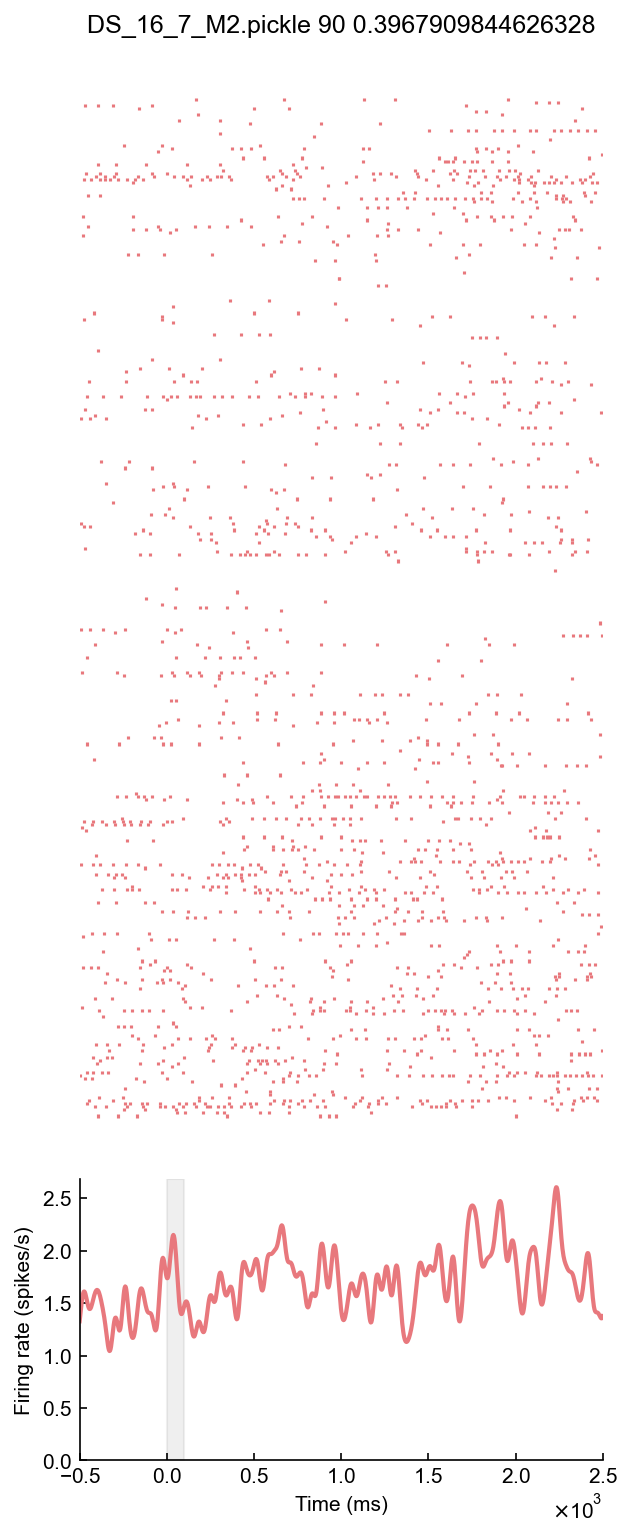

In [4]:
### SEPARATED BY GO/NOGO OR TARGET/NONTARGET

starttime = -500
endtime = 2500
units = 'ms'

height=10
width=1
trans=0.125
custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

n = 0


    
for idx in tqdm(range(len(clusters))):
    acc = accuracies[idx]
    
    if np.isnan(acc):
        continue
        
    #if (acc < 0.8):
    #    continue
    if (acc > 0.4):
        continue
    
    try:
        session = sessionIDs[idx]
        sessionfile = ilep.loadSessionCached(act_directory,session)
        clust = clusters[idx]
            
        conditions = ilep.getAllConditions(sessionfile,clust)
                
        plt.close('all')
        fig = plt.figure(figsize=(4.5,12.5))
        gs = fig.add_gridspec(2,1,height_ratios=[4,1],hspace=0.0125)#,wspace=0.5)#0.1)
        ax1 = plt.subplot(gs[0,0])#Raster
        ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
            
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
            
        color=NCR_CR_cmap(   ((sessionfile.responsiveness[clust]['all_trials'].FRmodulation)-1)   /5)
            
        #Plot Rasters
        try:
            times = ilep.getRaster(sessionfile,clust,conditions['all_trials'],startbuffer=0.5,units=units)
            #print(times)
            ax1.eventplot(times,color=color)
        except Exception as e:
            print('Rasters: '+str(e))
            
        #ticks = list(ax1.get_yticks())
        #ticks.append(1)
        #ticks.append(len(conditions['all_trials'].trials))
        #ticks = np.unique(ticks)
        #ax1.set_yticks(ticks)
            
        #ylims1 = np.array([0,len(conditions['all_trials'].trials)])+1
        #ax1.set_ylim(ylims1)
            
        if sessionfile.meta.task == 'switch':
            reversaltrial = np.less(conditions['all_trials'].trials,sessionfile.meta.first_reversal_trial)
            reversaltrial = np.sum(reversaltrial)+0.5
                
            xlims = ax1.get_xlim()
            ax1.plot(xlims,[reversaltrial,reversaltrial],linestyle='--',lw=1,color='k')
            ax1.set_xlim(xlims)
                
        #ax1.fill_between([0,100],[ylims1[1],ylims1[1]],color='grey',alpha=trans)
        #ax1.set_ylabel('Trial')
            
        #Plot PSTHs
        try:
            X,FR = ilep.getPSTH(sessionfile,clust,conditions['all_trials'], PSTHstart = starttime, PSTHend = endtime, units = 'ms', bw=0.02)
            ax2.plot(X,FR,color=color,lw=2)
        except Exception as e:
            print('PSTHs: '+str(e)) 
        ylims2 = ax2.get_ylim()
        ax2.fill_between([0,100],[ylims2[1],ylims2[1]],color='grey',alpha=trans)
        ax2.set_ylabel('Firing rate (spikes/s)')
        ax2.set_xlabel('Time (ms)')
            
        ax2.set_ylim([0,ylims2[1]])
            
        #ax2.set_xticks([-500,0,500,1000,1500,2000,2500])
        #ax2.set_xticklabels(['-500','0','500','1000','1500','2000','2500'])
            
        ax1.set_xlim([-500,2500])
        ax2.set_xlim([-500,2500])
        #ax2.set_xticks([0,10,20,30,100])

        print(session)
        n += 1
        
        ax1.set_title(session + ' ' + str(clust) + ' ' + str(acc))
            
        fig.savefig(os.path.join('D:\\\\TempFigures','Decoding Rasters','Low Decoders','Low Decoder '+str(n)+'.png'),transparent=False,facecolor="white")
        #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PNGs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.png'),transparent=False,facecolor="white")
        #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',task,'PDFs',sessionfile.meta.region,session + ' cluster ' + str(clust) + ' TargNontarg.pdf'),transparent=False,facecolor="white")
        #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PNGs',session + ' cluster ' + str(clust) + '.png'),transparent=False,facecolor="white")
        #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','PDFs',session + ' cluster ' + str(clust) + '.pdf'),transparent=False,facecolor="white")
    except Exception as e:
        raise

# Rasters -- November 2022 -- SfN and Manuscript. Modeled after BioRxiv RNN paper

In [86]:
#filename = 'D:\\MouseDataStimulusDecodingCached.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached4858units2022-09-23.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5632units2022-10-05.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv'
filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv'

#filename = 'D:\\MouseDatastimulusDecodingCached5759units2022-10-07.csv'#eLife Criterion

mouse_df = pd.read_csv (filename)

sessionIDs = mouse_df['sessions']
clusters = mouse_df['clusters']
accuracies = mouse_df['accuracies']
accuracies_std = mouse_df['accuracies_std']
accuracies_sem = mouse_df['accuracies_sem']
waccuracies = mouse_df['waccuracies']
waccuracies_std = mouse_df['waccuracies_std']
waccuracies_sem = mouse_df['waccuracies_sem']
caccuracies = mouse_df['caccuracies']
#caccuracies_std = mouse_df['caccuracies_std']
caccuracies_sem = mouse_df['caccuracies_sem']
pvals = mouse_df['pvals']

categories = 'stimulus'

# Generate Learning Phases (from curves)

In [88]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
#animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

In [89]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=False
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.png'),transparent=False,facecolor="white")
    pass

BS_40
BS_41
BS_42
BS_49
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


In [100]:
EILphases = ['ERROR']*len(sessionIDs)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    
    EILphase = 'ERROR'
    try:
        if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre early'
        elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre int'
        elif sessionfile.meta.condition == 'prereversal expert':
            EILphase = 'pre late'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post early'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post int'
        elif sessionfile.meta.condition == 'postreversal expert':
            EILphase = 'post late'
        elif sessionfile.meta.condition == 'reversal':
            EILphase = 'switch'
        else:
            pass
    except Exception as e:
        #raise e
        EILphase = 'ERROR'
        
    EILphases[idx] = EILphase
    
print(EILphases)

5801it [00:22, 255.38it/s]

['pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'pre late', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', 'switch', '

# Non Switch

5801it [6:37:13,  4.11s/it]


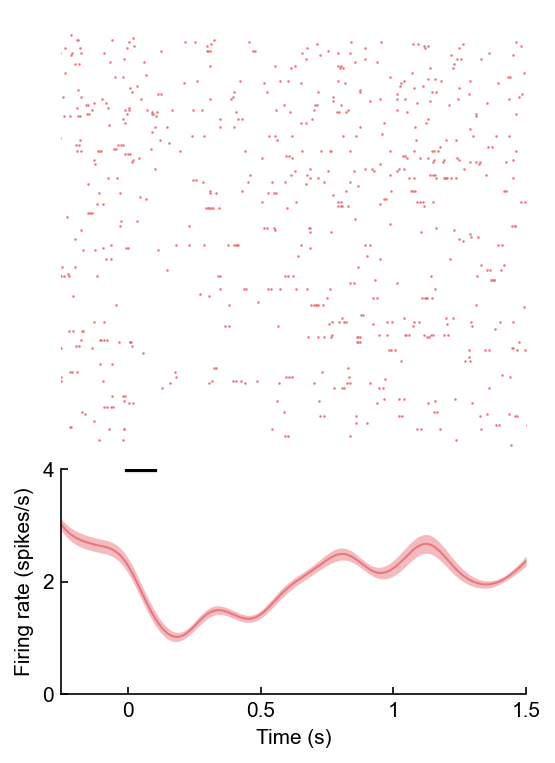

In [119]:
starttime = -250
endtime = 1500
bw_scott_factor = 3

buffer = 500
bufferedstart = starttime - buffer
bufferedend = endtime + buffer
startbuffer = (0-bufferedstart)/1000
endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

# EnumSession = []
# EnumClust = []
# sessions = os.listdir(act_directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(act_directory,session)
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)
        
#EnumSession = EnumSession[0:2]
#EnumClust = EnumClust[0:2]
    
session = None
for idx,(this_session,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    plt.close('all')
    if this_session != session:
        session = this_session
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
    #########################################################################################
        
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod < 2:
        FRmodCategory = 'NCR'
    elif FRmod > 8:
        FRmodCategory = 'CR'
    else:
        FRmodCategory = 'Middle'
    #Skip unidentified category neurons
    if FRmodCategory == 'ERROR':
        continue
        
    region = sessionfile.meta.region
    
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR']:
        continue
        
    #if EIL != 'pre late':
    #    continue
        
    #########################################################################################
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    trialsToPlot = sessionfile.trim[clust].trimmed_trials
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
    if EIL == 'switch':
        try:
            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
        except:
            pass
        
    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)
    
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')
    
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")

# Switch - Pre

In [124]:
starttime = -250
endtime = 1500
bw_scott_factor = 3

buffer = 500
bufferedstart = starttime - buffer
bufferedend = endtime + buffer
startbuffer = (0-bufferedstart)/1000
endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

# EnumSession = []
# EnumClust = []
# sessions = os.listdir(act_directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(act_directory,session)
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)
        
#EnumSession = EnumSession[0:2]
#EnumClust = EnumClust[0:2]
    
session = None
for idx,(this_session,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    plt.close('all')
    if this_session != session:
        session = this_session
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
    #########################################################################################
        
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod < 2:
        FRmodCategory = 'NCR'
    elif FRmod > 8:
        FRmodCategory = 'CR'
    else:
        FRmodCategory = 'Middle'
    #Skip unidentified category neurons
    if FRmodCategory == 'ERROR':
        continue
        
    region = sessionfile.meta.region
    
    EIL = EILphases[idx]
    
    #Skip non-switch
    if EIL != 'switch':
        continue
        
    #########################################################################################
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    all_conditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = all_conditions['pre-switch'].trials #Note that this *is* trimmed already
    
    if len(trialsToPlot) >= 100:
        continue
        
    if len(trialsToPlot) <= 10:
        continue
    
    FRmod = sessionfile.responsiveness[clust]['pre-switch'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
    if EIL == 'switch':
        try:
            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
        except:
            pass
        
    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)
    
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')
    
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,'switchpre','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,'switchpre','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")

5801it [00:50, 115.93it/s]


# Switch - Post

In [122]:
starttime = -250
endtime = 1500
bw_scott_factor = 3

buffer = 500
bufferedstart = starttime - buffer
bufferedend = endtime + buffer
startbuffer = (0-bufferedstart)/1000
endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

# EnumSession = []
# EnumClust = []
# sessions = os.listdir(act_directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(act_directory,session)
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)
        
#EnumSession = EnumSession[0:2]
#EnumClust = EnumClust[0:2]
    
session = None
for idx,(this_session,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    plt.close('all')
    if this_session != session:
        session = this_session
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
    #########################################################################################
        
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod < 2:
        FRmodCategory = 'NCR'
    elif FRmod > 8:
        FRmodCategory = 'CR'
    else:
        FRmodCategory = 'Middle'
    #Skip unidentified category neurons
    if FRmodCategory == 'ERROR':
        continue
        
    region = sessionfile.meta.region
    
    EIL = EILphases[idx]
    
    #Skip non-switch
    if EIL != 'switch':
        continue
        
    #########################################################################################
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    all_conditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = all_conditions['post-switch'].trials #Note that this *is* trimmed already
    
    if len(trialsToPlot) <= 100:
        continue
    
    FRmod = sessionfile.responsiveness[clust]['post-switch'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
    #if EIL == 'switch':
    #    try:
    #        switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
    #        ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
    #    except:
    #        pass
        
    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)
    
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')
    
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,'switchpost','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,'switchpost','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")

5801it [30:36,  3.16it/s]


In [12]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

# Choice-aligned raster plots

In [6]:
filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv'

mouse_df = pd.read_csv (filename)

sessionIDs = mouse_df['sessions']
clusters = mouse_df['clusters']
accuracies = mouse_df['accuracies']
accuracies_std = mouse_df['accuracies_std']
accuracies_sem = mouse_df['accuracies_sem']
waccuracies = mouse_df['waccuracies']
waccuracies_std = mouse_df['waccuracies_std']
waccuracies_sem = mouse_df['waccuracies_sem']
caccuracies = mouse_df['caccuracies']
#caccuracies_std = mouse_df['caccuracies_std']
caccuracies_sem = mouse_df['caccuracies_sem']
pvals = mouse_df['pvals']

categories = 'stimulus'

# Generate Learning Phases (from curves)

In [7]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
#animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

In [8]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=False
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.png'),transparent=False,facecolor="white")
    pass

BS_40
BS_41
BS_42
BS_49
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


In [10]:
EILphases = ['ERROR']*len(sessionIDs)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    
    EILphase = 'ERROR'
    try:
        if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre early'
        elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre int'
        elif sessionfile.meta.condition == 'prereversal expert':
            EILphase = 'pre late'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post early'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post int'
        elif sessionfile.meta.condition == 'postreversal expert':
            EILphase = 'post late'
        elif sessionfile.meta.condition == 'reversal':
            EILphase = 'switch'
        else:
            pass
    except Exception as e:
        #raise e
        EILphase = 'ERROR'
        
    EILphases[idx] = EILphase
    
#print(EILphases)

5801it [00:23, 246.44it/s]


# Non-switch

0it [00:00, ?it/s]


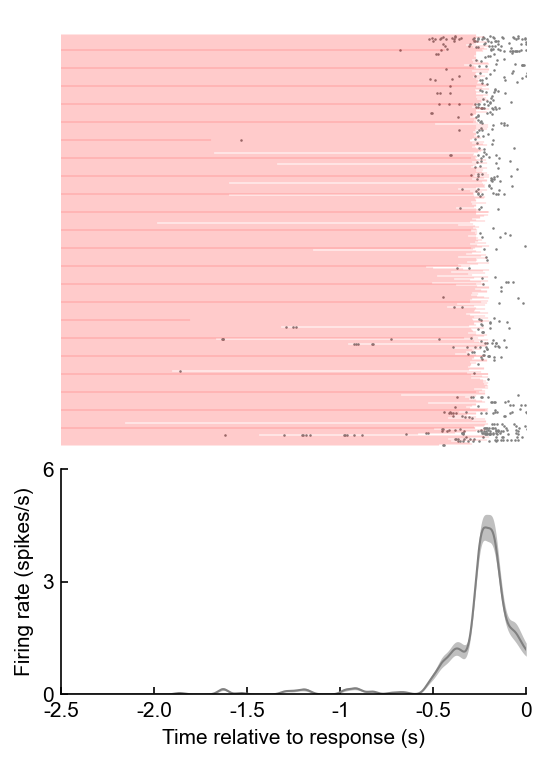

In [33]:
#starttime = -250
#endtime = 250
bw_scott_factor = 3

buffer = 500
bufferedstart = starttime - buffer
bufferedend = endtime + buffer
startbuffer = (0-bufferedstart)/1000
endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

# EnumSession = []
# EnumClust = []
# sessions = os.listdir(act_directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(act_directory,session)
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)
        
#EnumSession = EnumSession[0:2]
#EnumClust = EnumClust[0:2]
    
session = None
for idx,(this_session,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    plt.close('all')
    if this_session != session:
        session = this_session
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
    #########################################################################################
        
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    if FRmod < 2:
        FRmodCategory = 'NCR'
    elif FRmod > 8:
        FRmodCategory = 'CR'
    else:
        FRmodCategory = 'Middle'
    #Skip unidentified category neurons
    if FRmodCategory == 'ERROR':
        continue
        
    region = sessionfile.meta.region
    
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR']:
        continue
        
    #if EIL != 'pre late':
    #    continue
    
    response_times = get_response_times_with_default(sessionfile)
        
    #########################################################################################
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    trialsToPlot = sessionfile.trim[clust].trimmed_trials
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        #this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialend = response_times[trial]
        #trialstart = trialend - 2.5*sessionfile.meta.fs
        trialstart = sessionfile.trials.starts[trial]
        
        trialstart_buffer = trialstart - 0.25*30000
        trialend_buffer = trialend + 0.25*30000
        
        this_trial_idx = np.logical_and(np.greater(clustSpikes,trialstart_buffer) , np.less(clustSpikes,trialend_buffer))
        this_trial_spikes = clustSpikes[this_trial_idx] - trialend
        
        this_trial_spikes = this_trial_spikes*1000/30000
        
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
        trialend = response_times[trial]
        trialstart = sessionfile.trials.starts[trial]
        trial_duration = trialend-trialstart
        trial_duration = trial_duration * 1000 / 30000
        
        ax1.plot([-2500,-trial_duration],[idx,idx],color='red',lw=0.1)
        
    #if EIL == 'switch':
    #    try:
    #        switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
    #        ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
    #    except:
    #        pass
        
    #Plot PSTH
    starttime = -2500
    endtime = 0
    PSTHstart = starttime - 500
    PSTHend = endtime + 500
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)
    
    ax2.set_xlim([starttime,endtime])
    #ax2.set_xticks([0,500,1000,1500])
    #ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xticks([-0,-500,-1000,-1500,-2000,-2500])
    ax2.set_xticklabels(['0','-0.5','-1','-1.5','-2.0','-2.5'])
    ax2.set_xlabel('Time relative to response (s)')
    
    break
    #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters',region,FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white")
    #fig.savefig(os.path.join('D:\\\\TempFigures','Rasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")

# Rasters -- January 2023 -- Combined Stimulus and Choice period rasters (stimulus aligned)

20it [00:59,  2.94s/it]<ipython-input-50-e7569a1ef4e7>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,6))
99it [04:31,  2.74s/it]


MemoryError: In RendererAgg: Out of memory

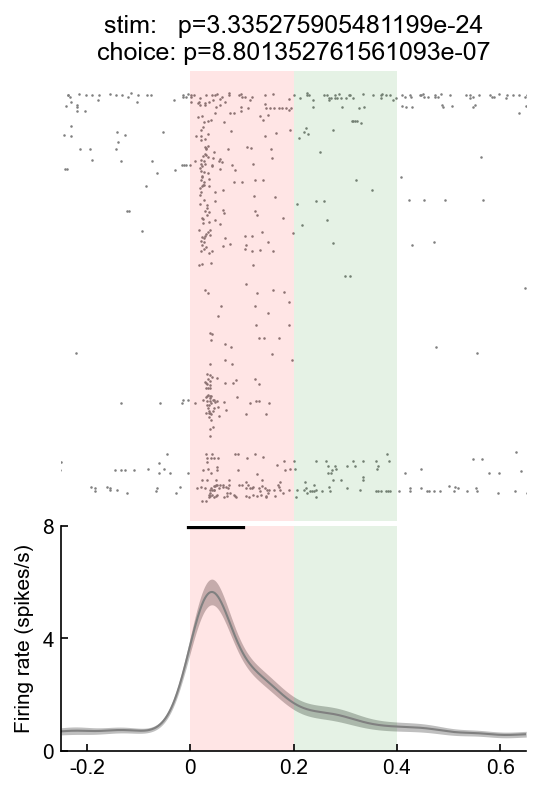

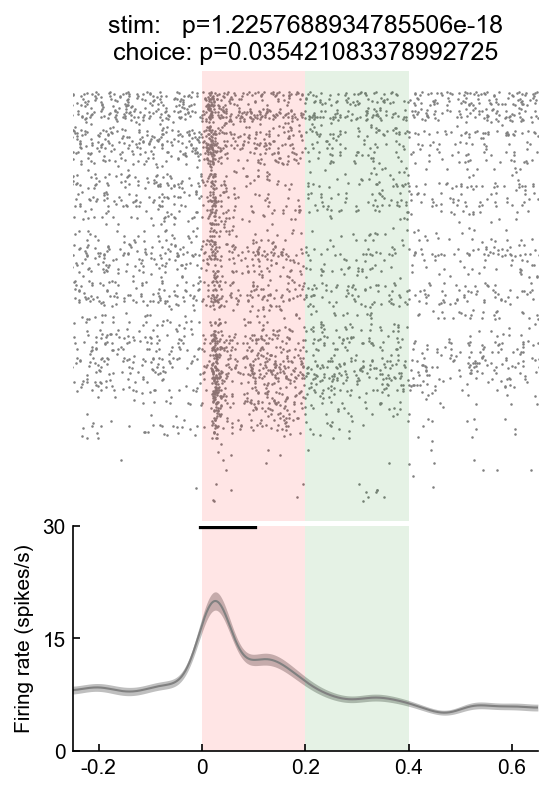

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

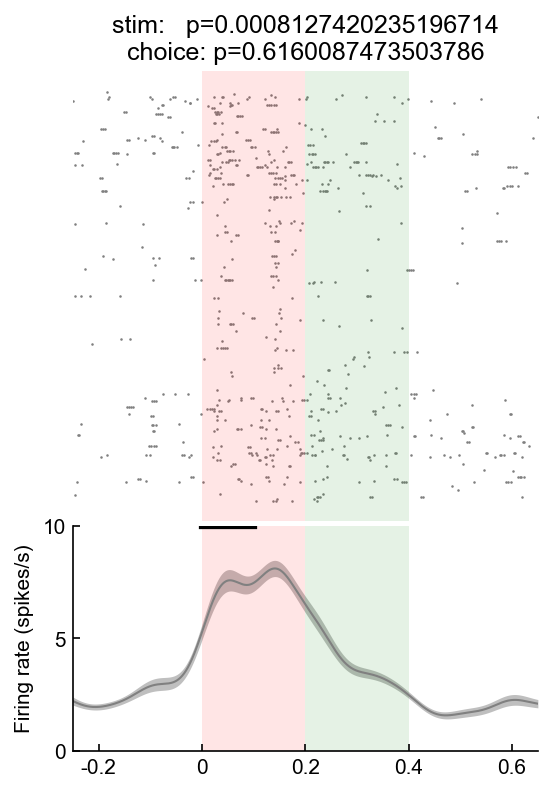

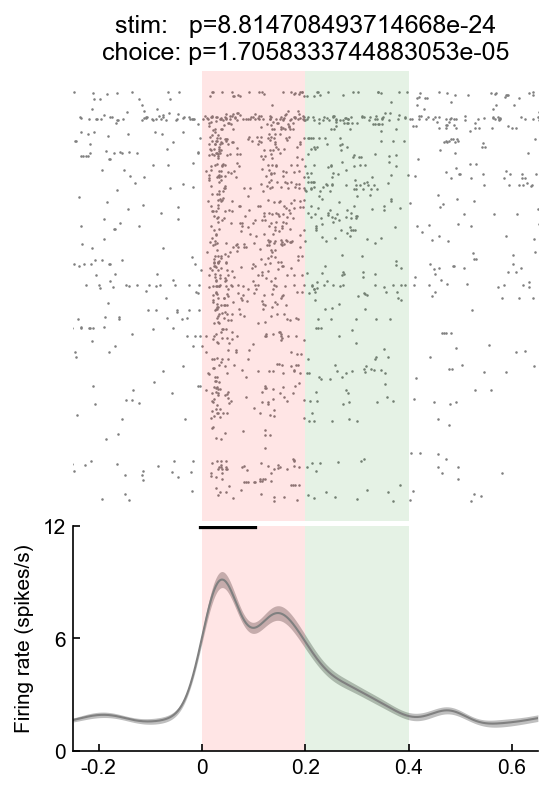

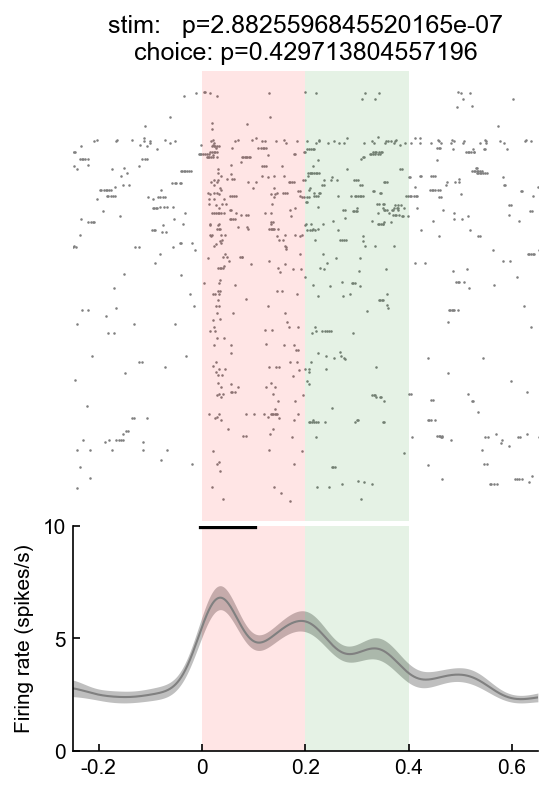

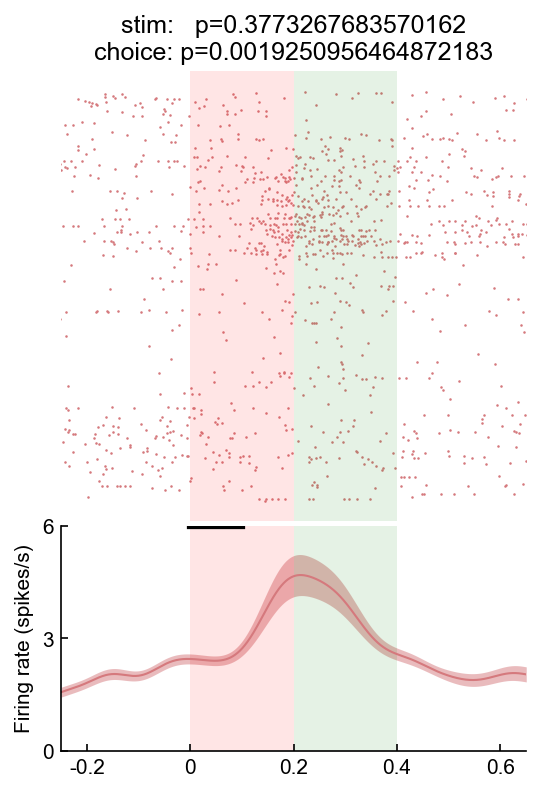

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

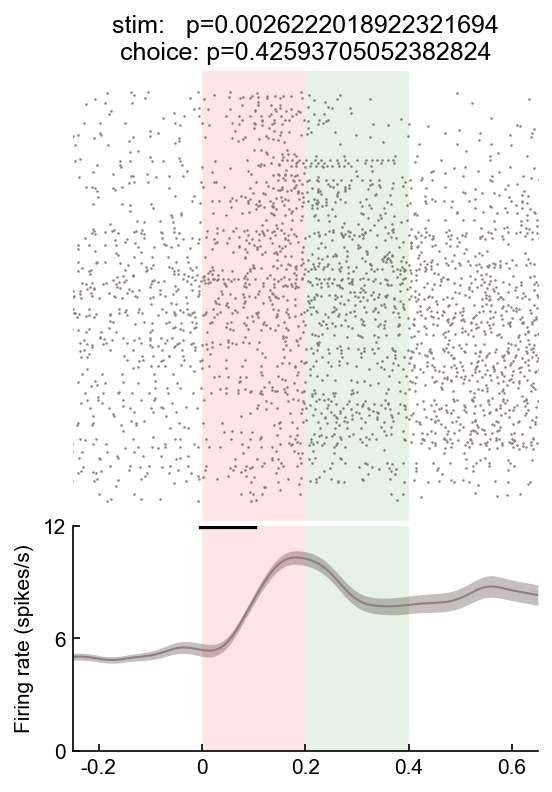

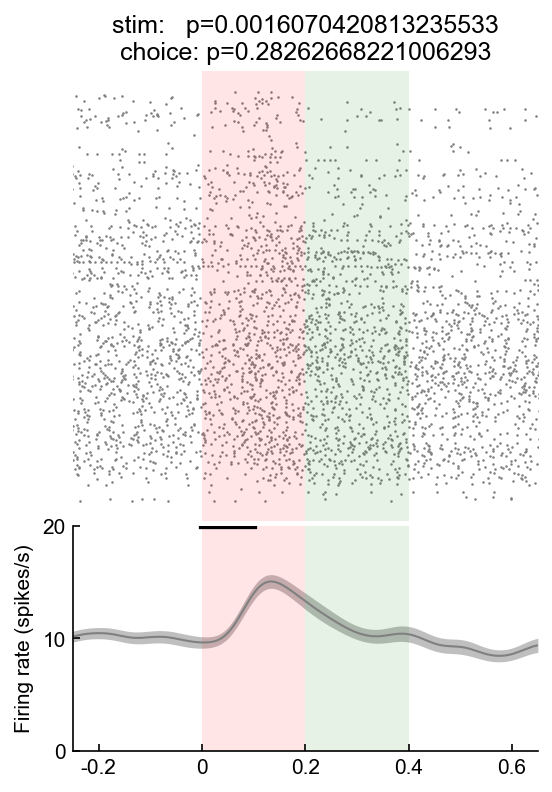

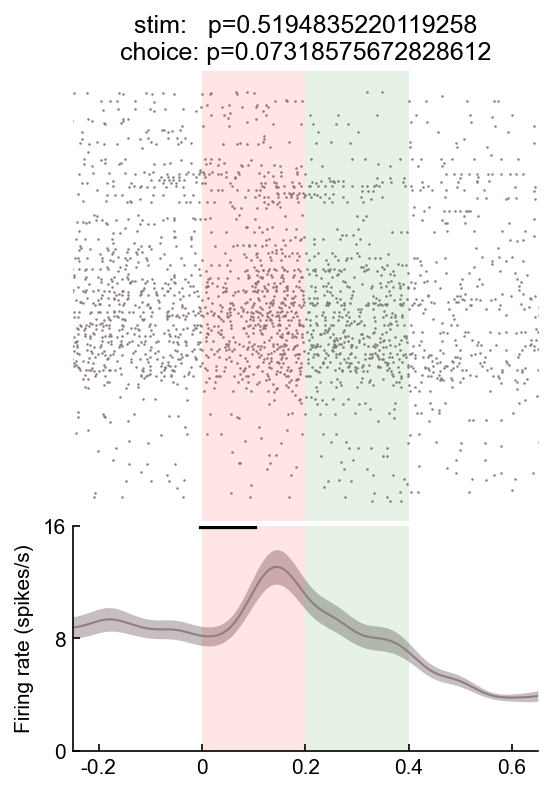

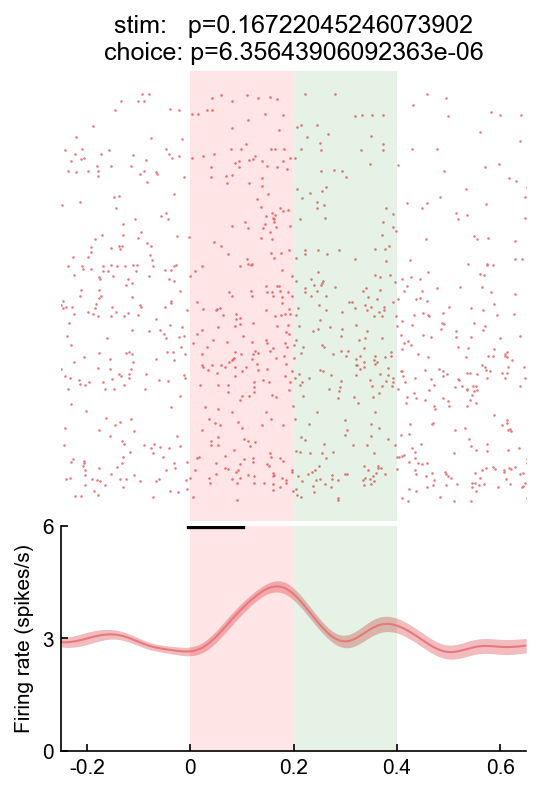

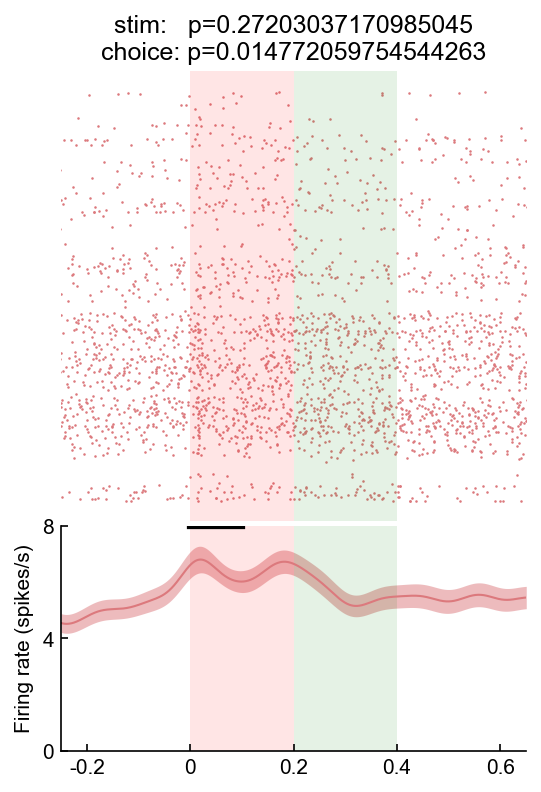

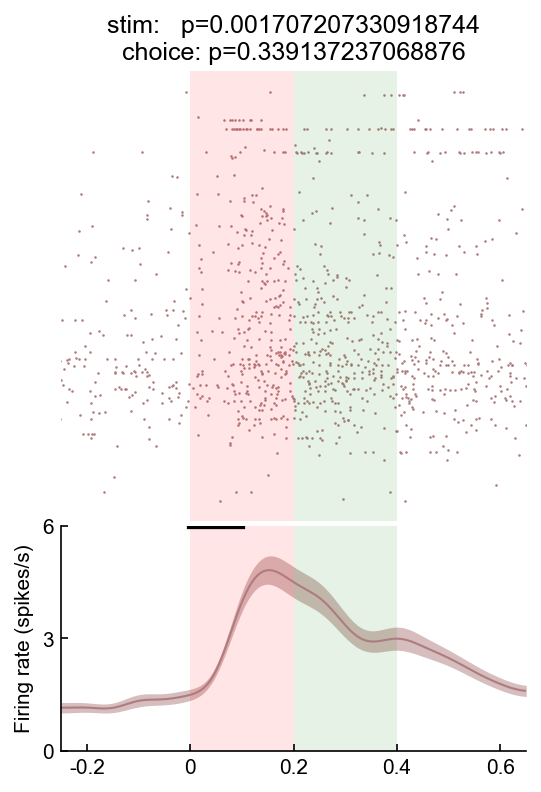

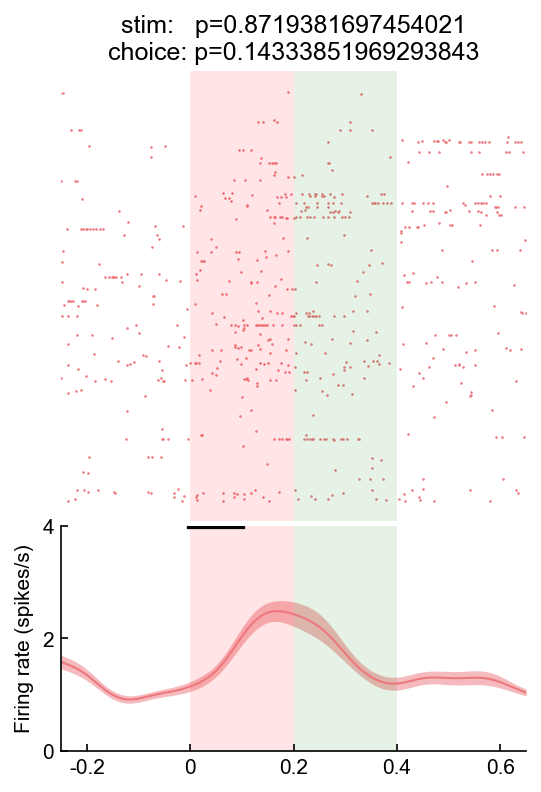

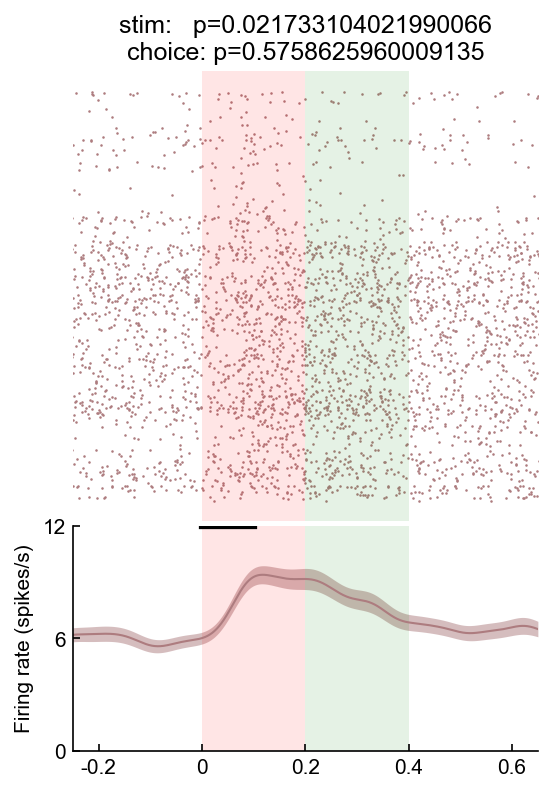

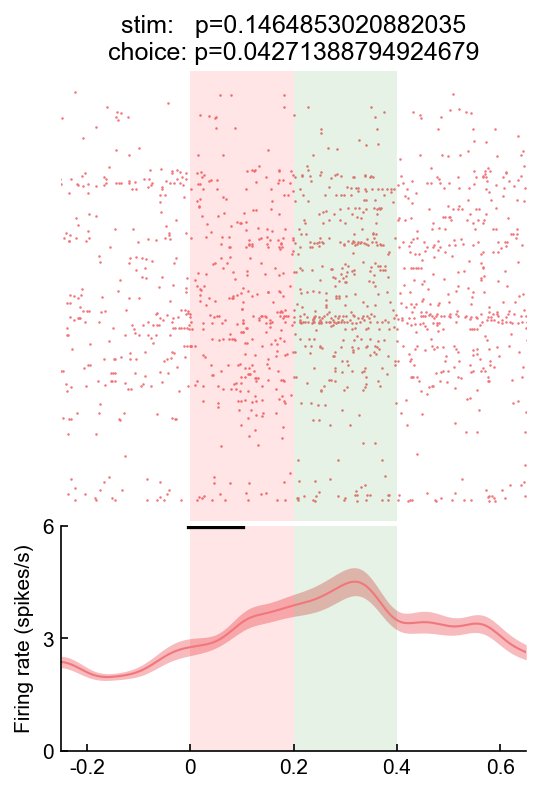

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

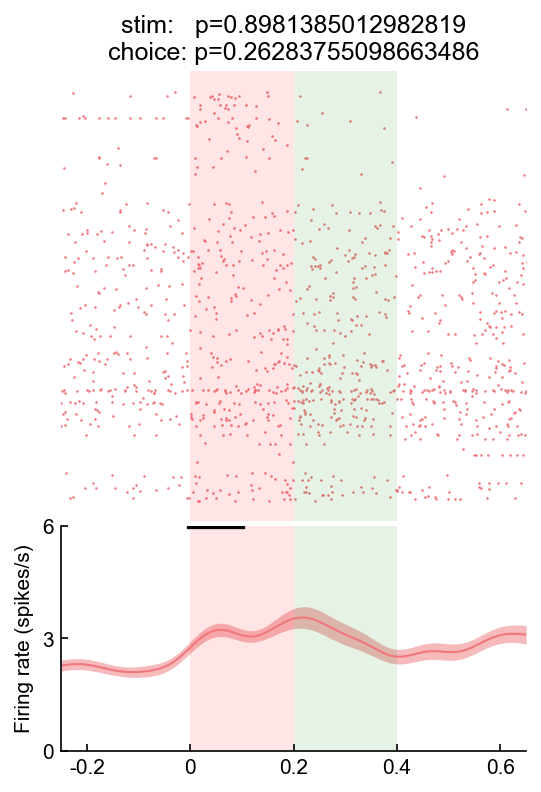

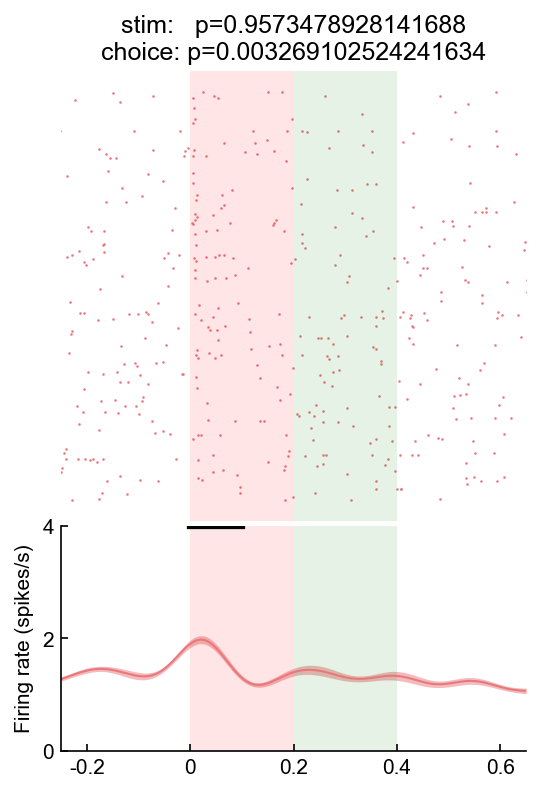

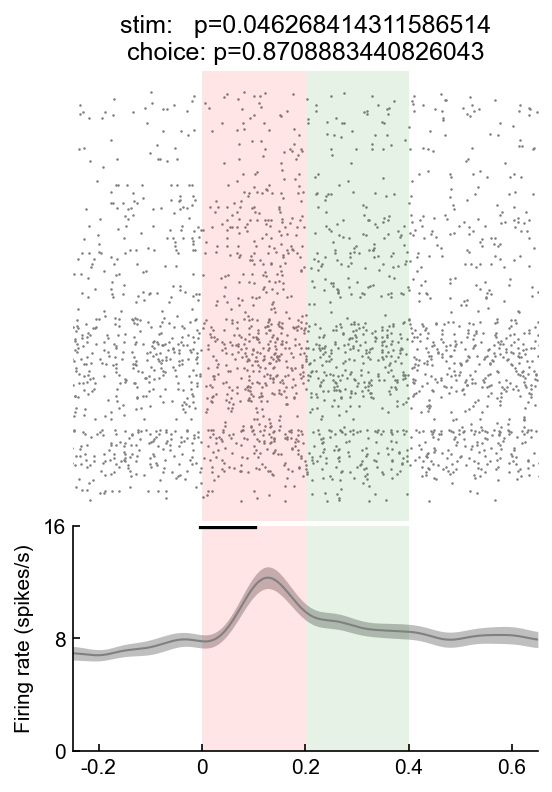

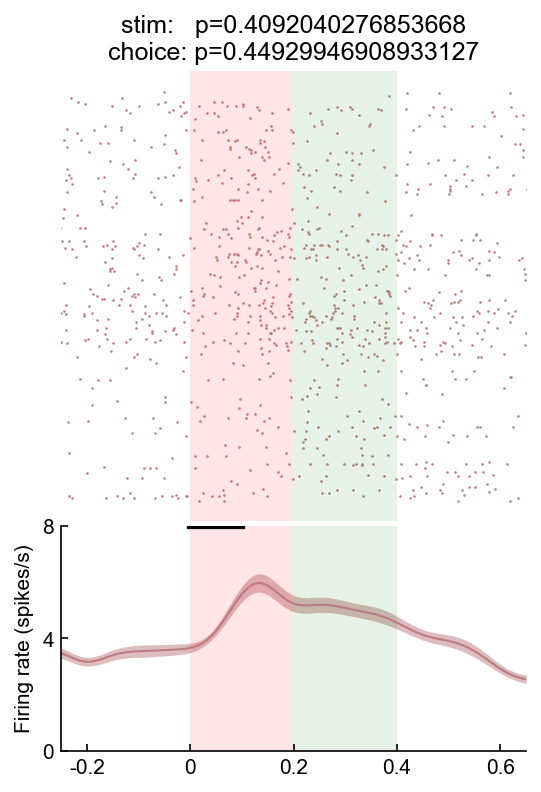

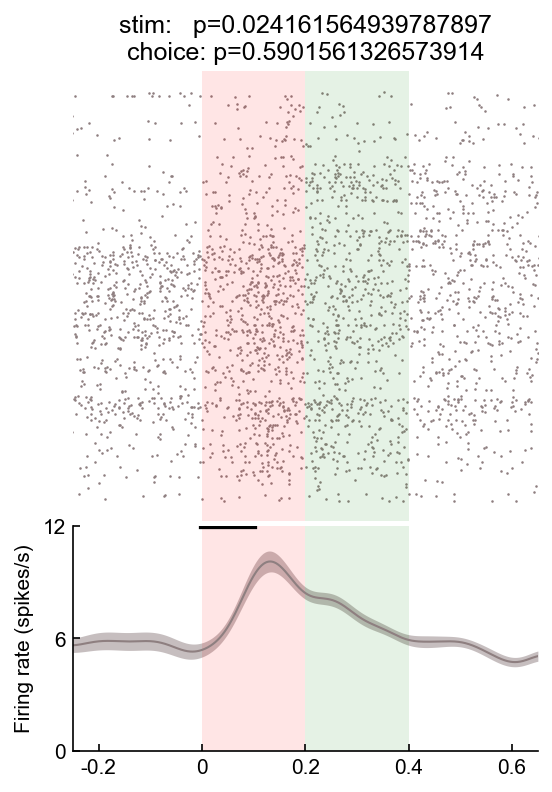

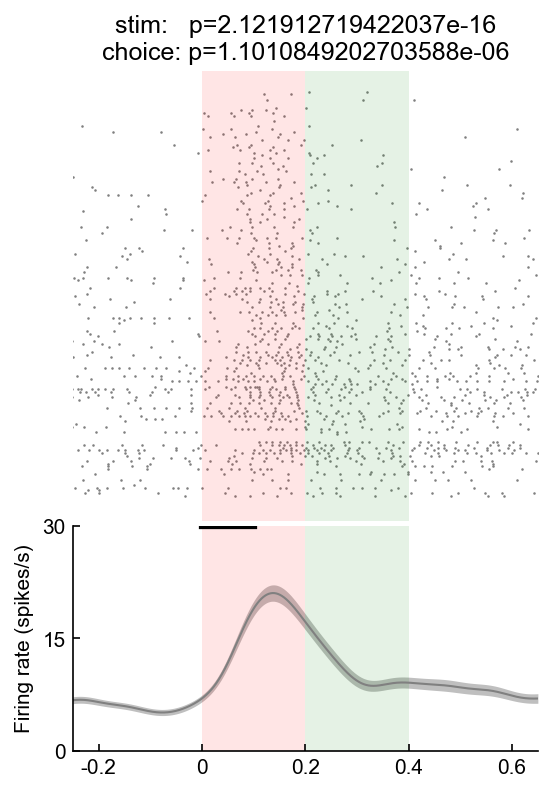

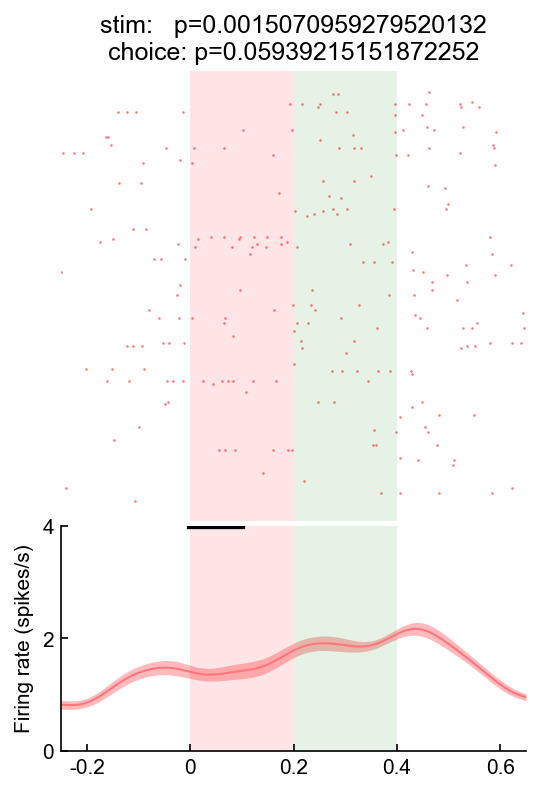

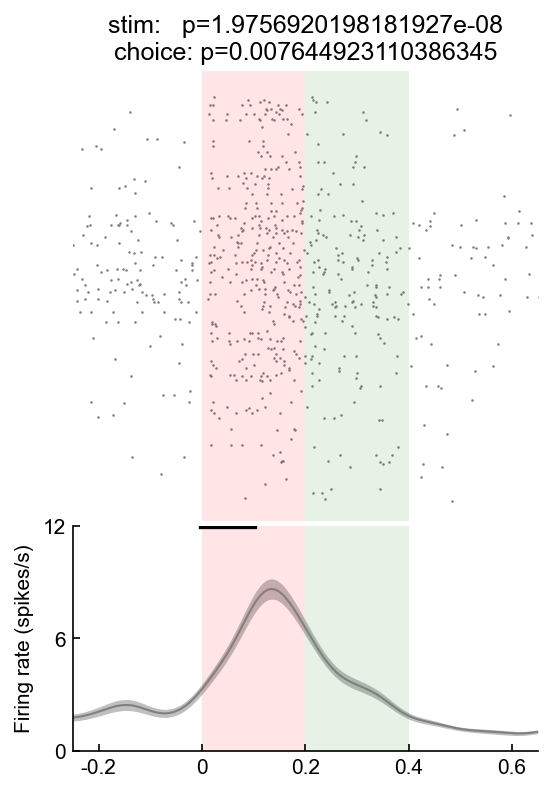

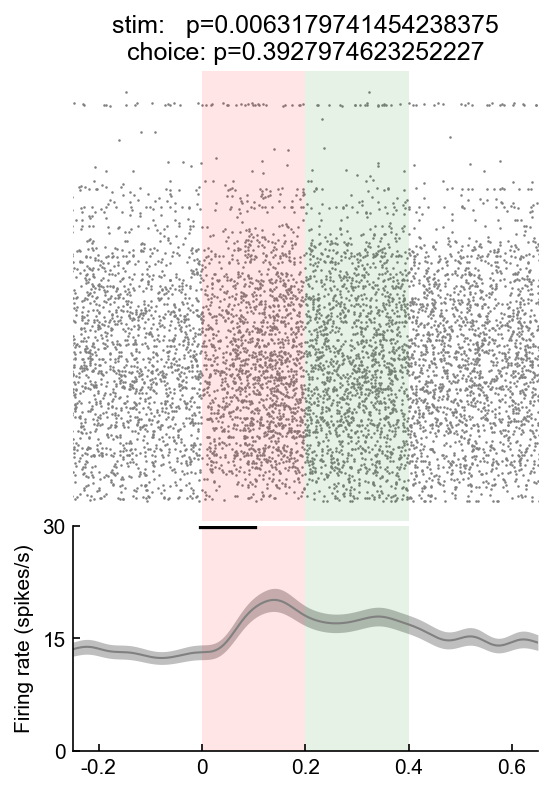

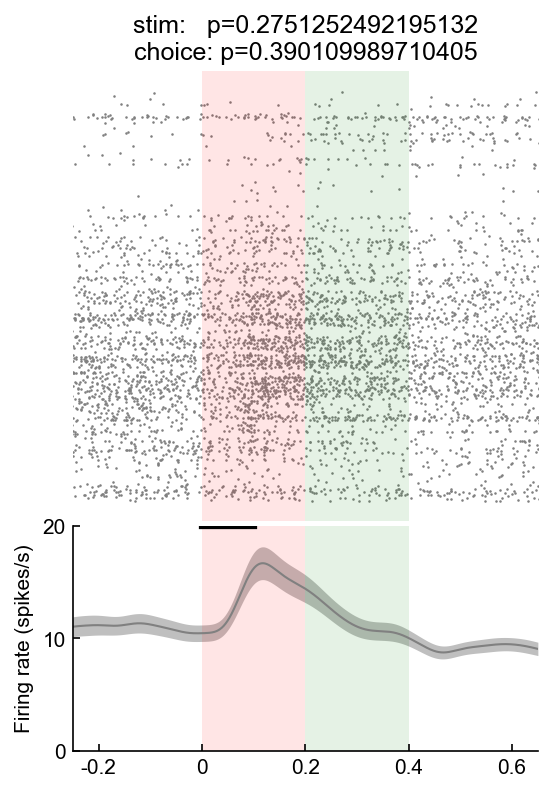

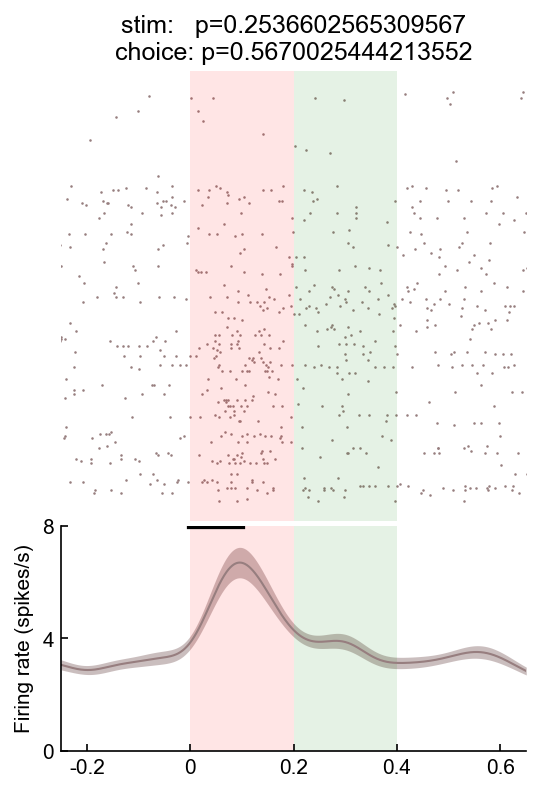

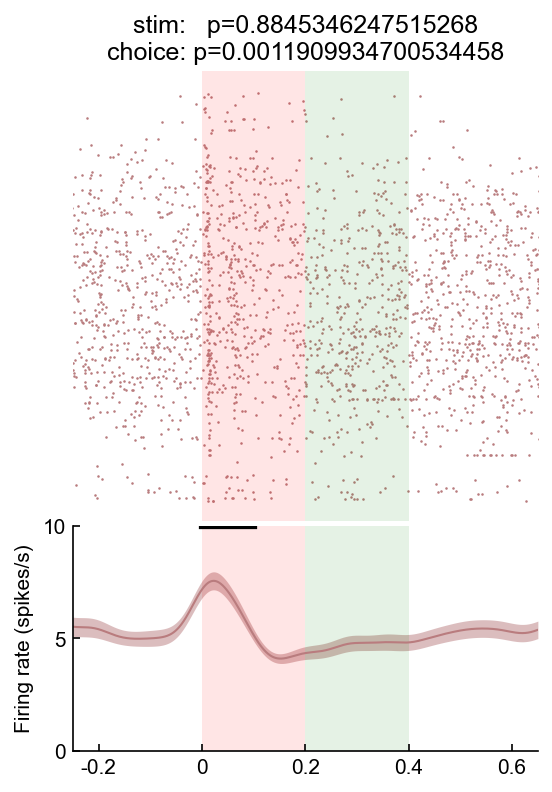

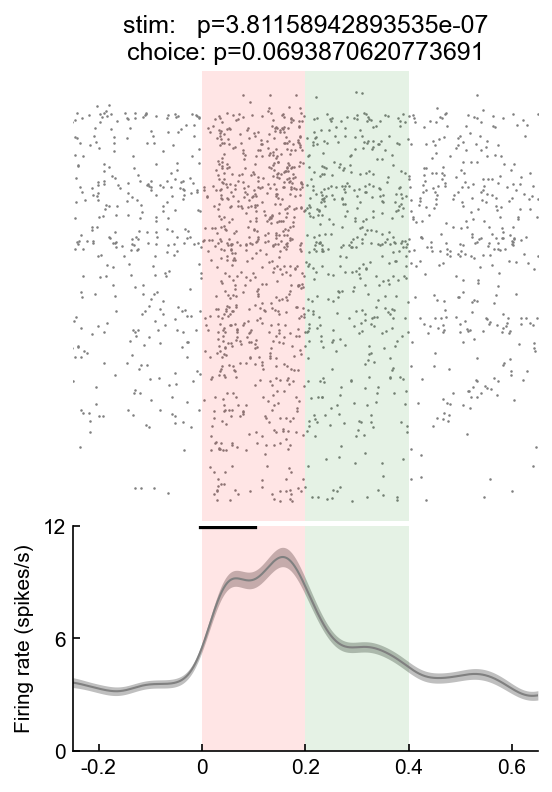

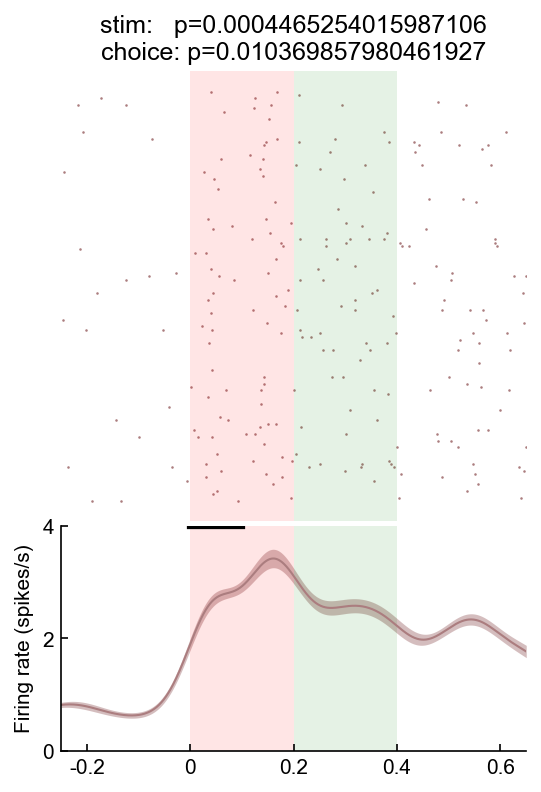

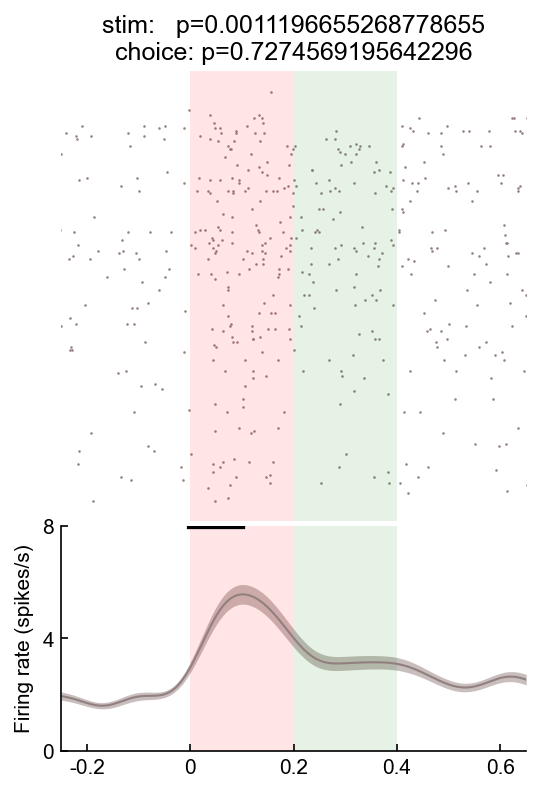

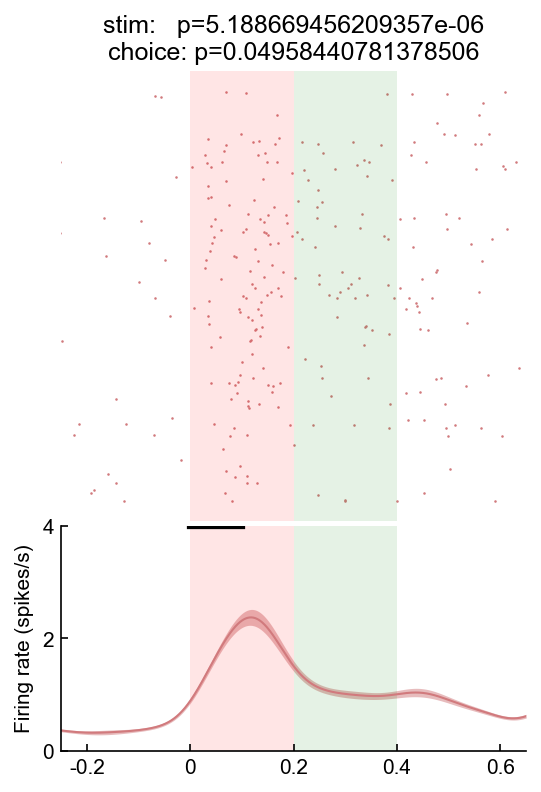

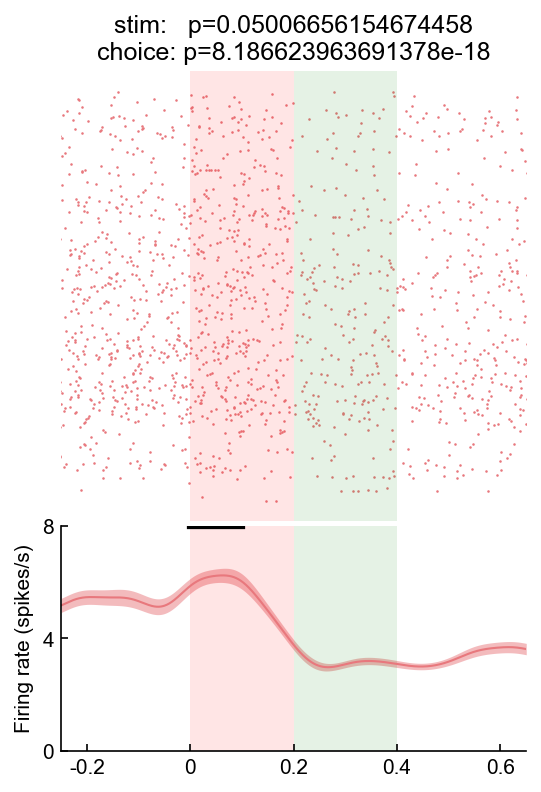

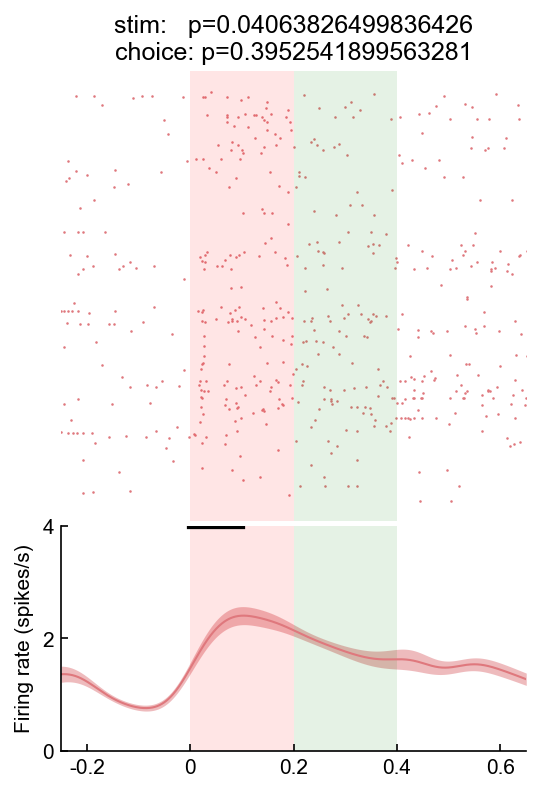

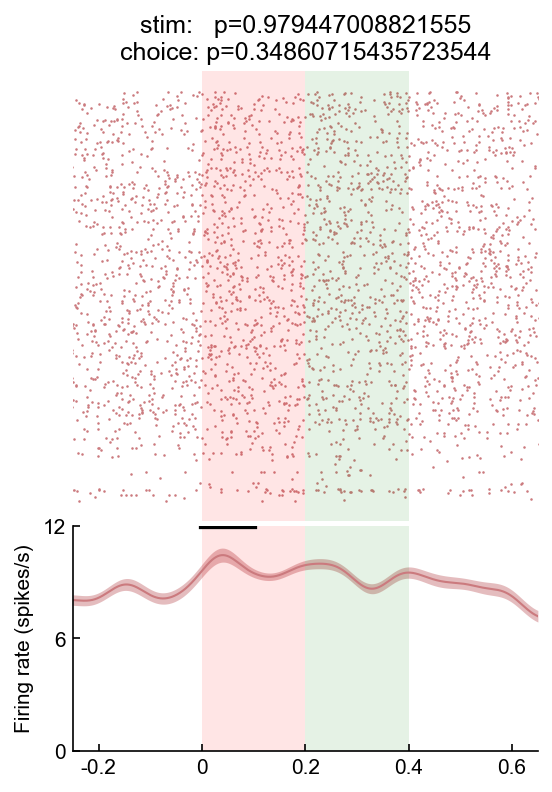

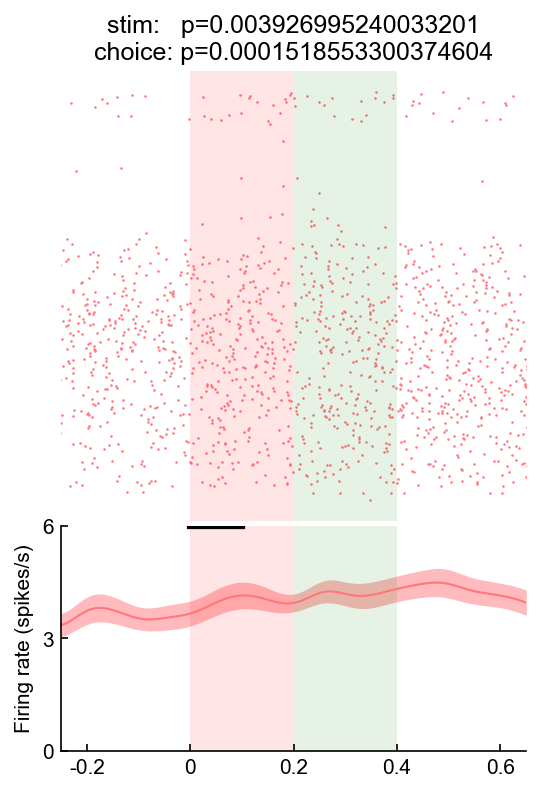

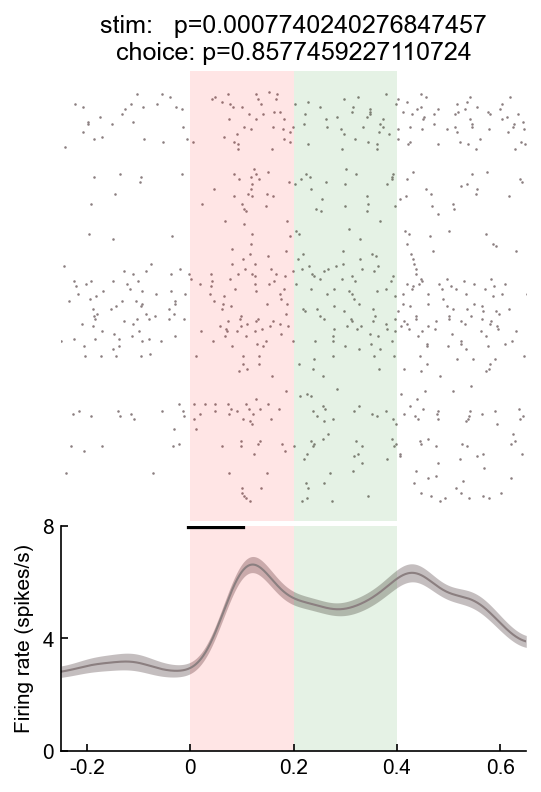

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

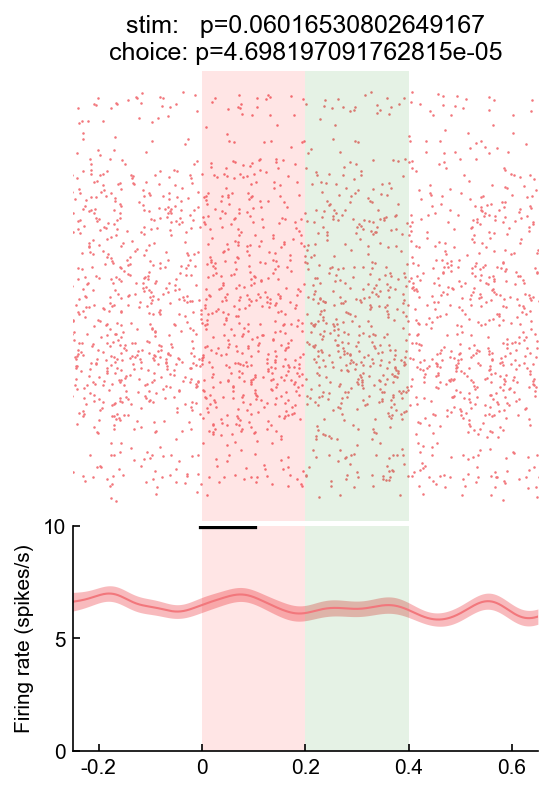

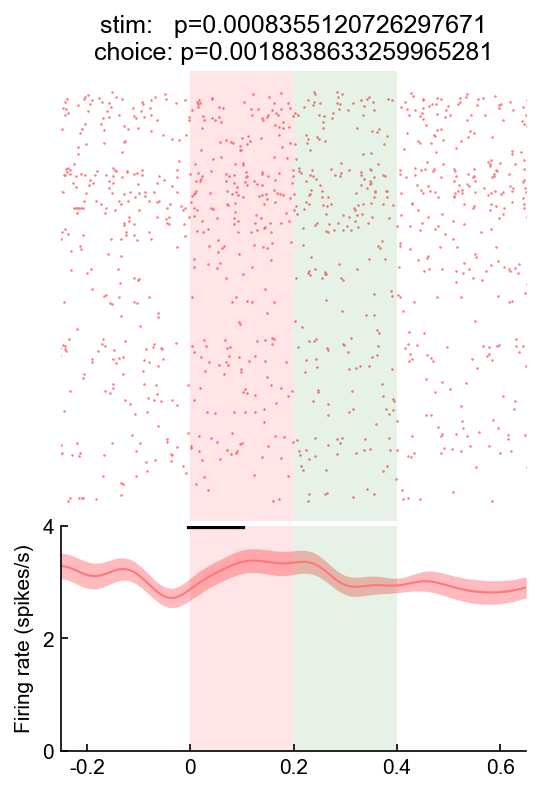

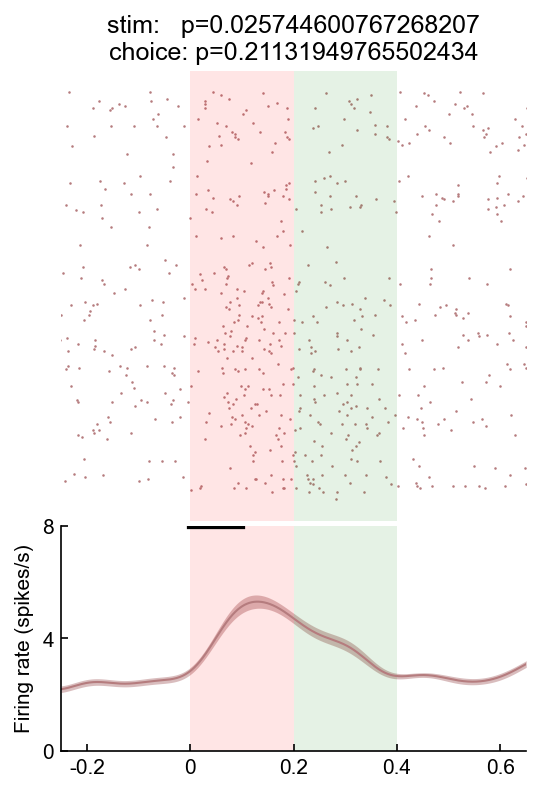

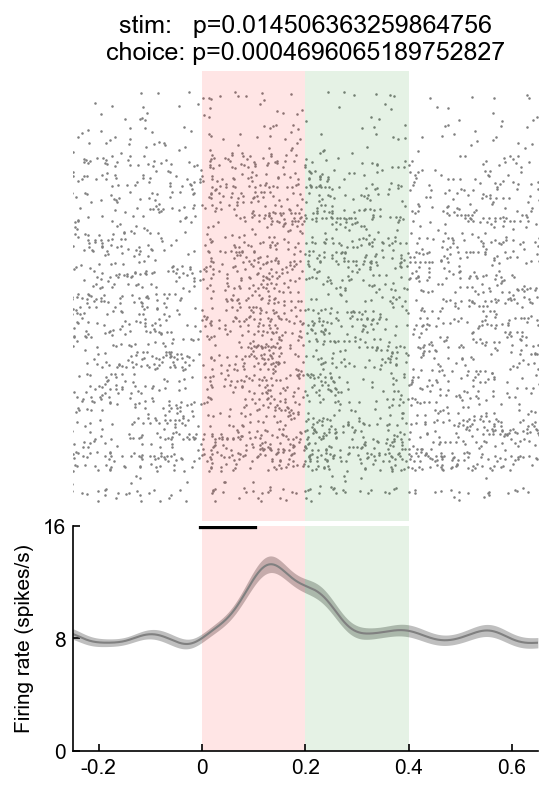

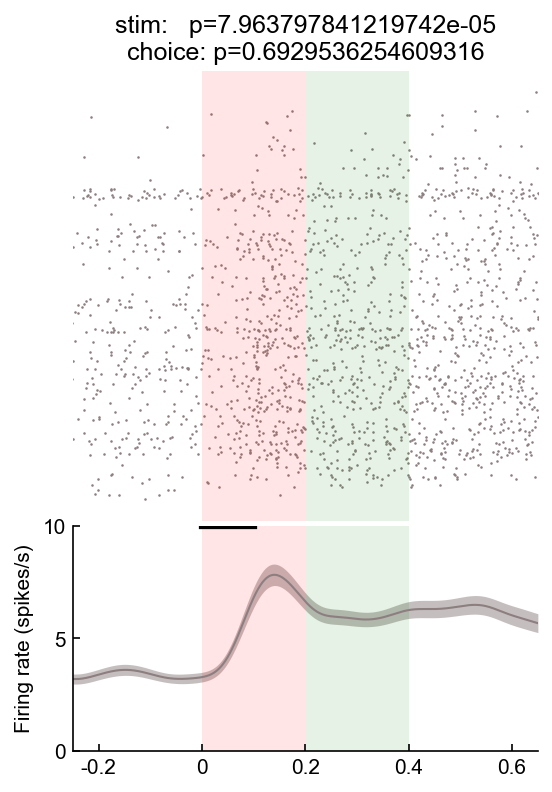

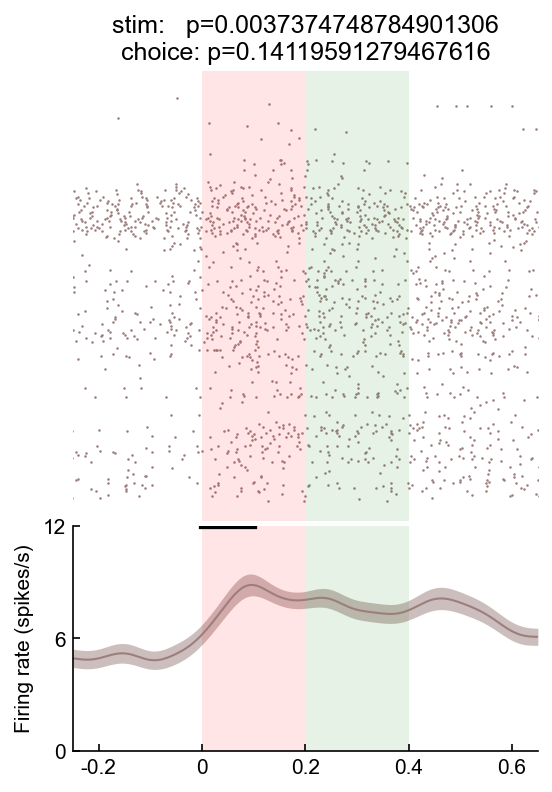

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

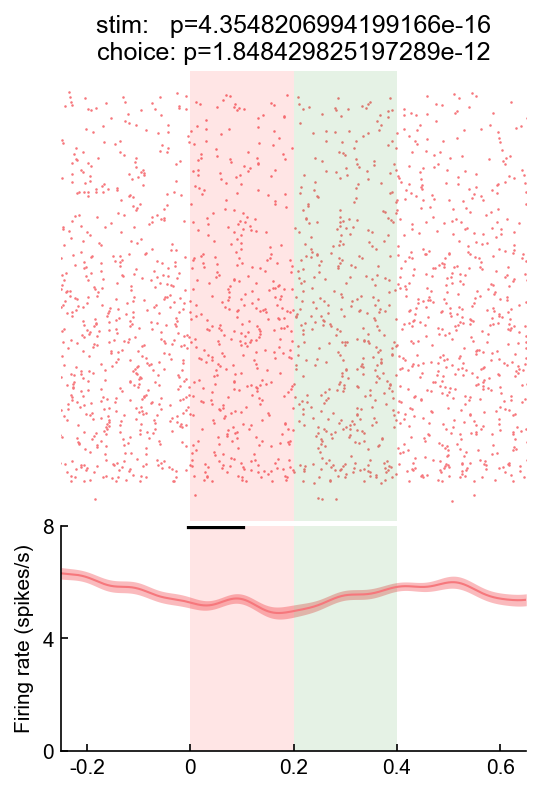

MemoryError: In RendererAgg: Out of memory

<Figure size 600x900 with 2 Axes>

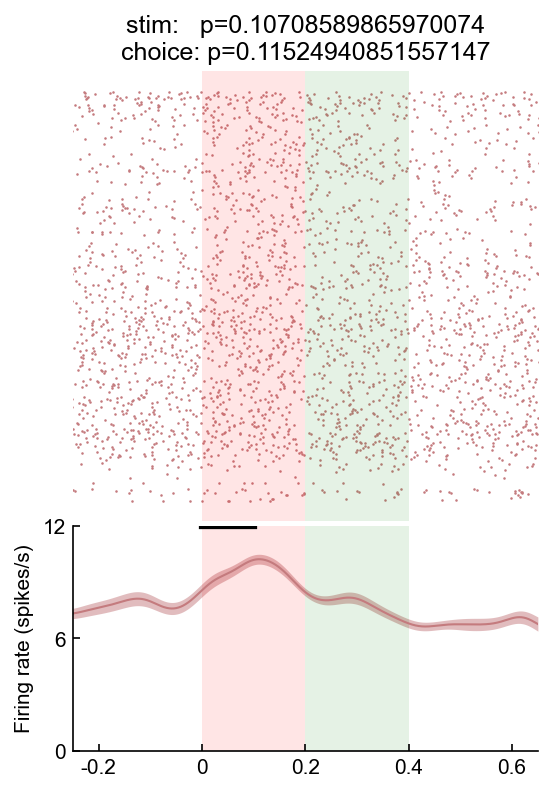

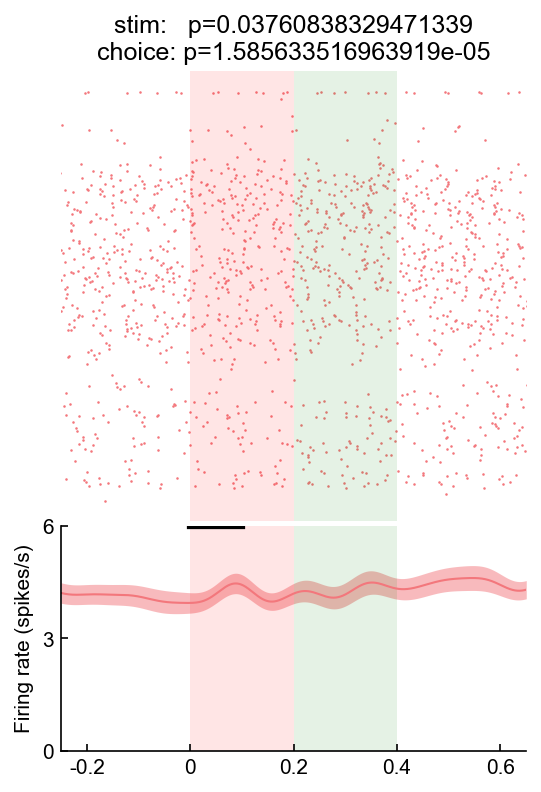

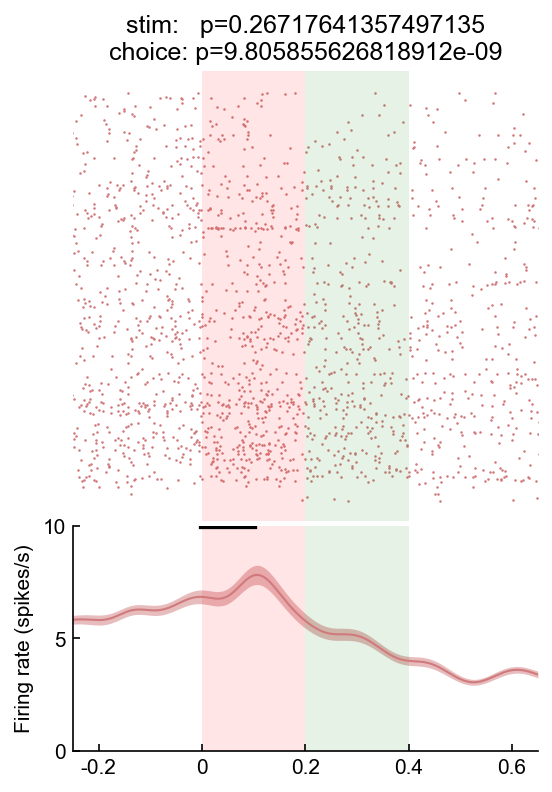

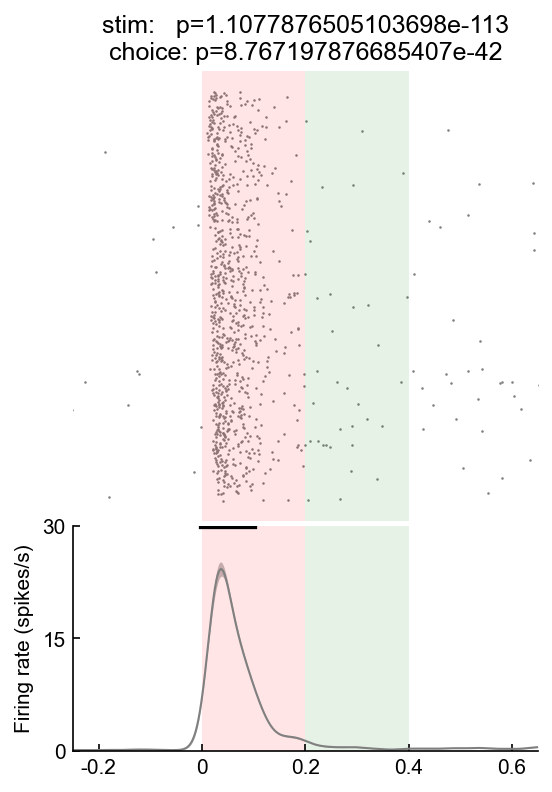

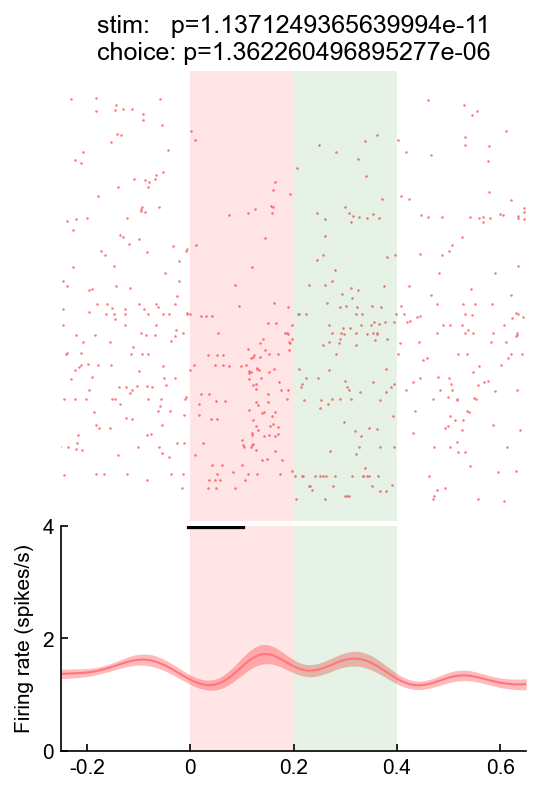

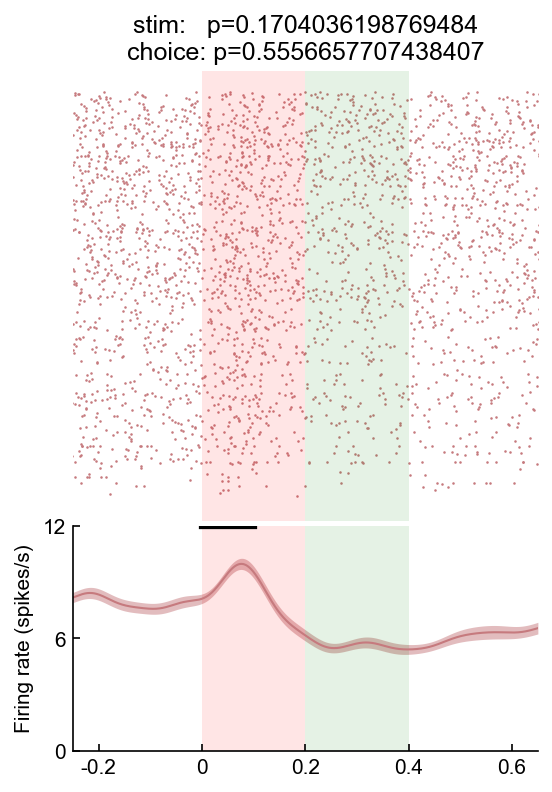

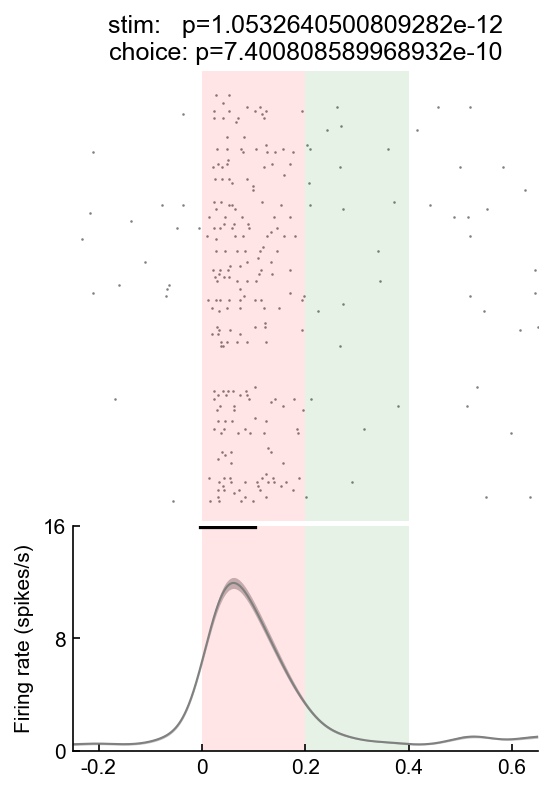

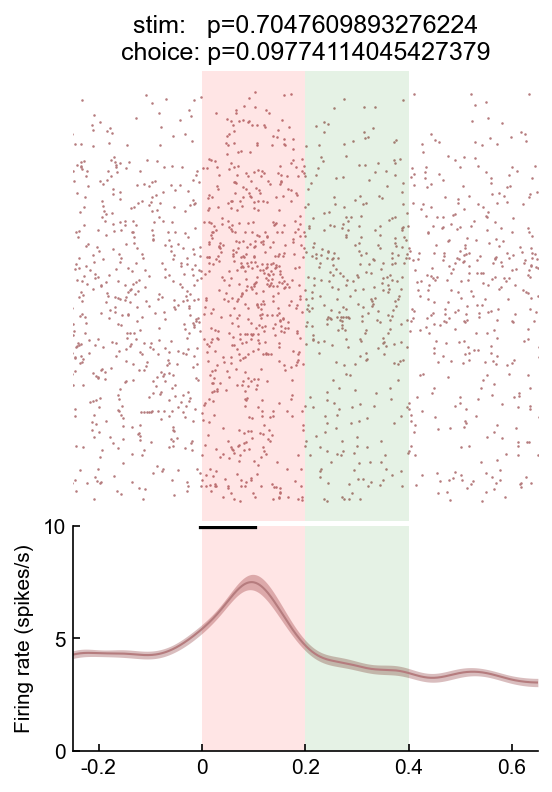

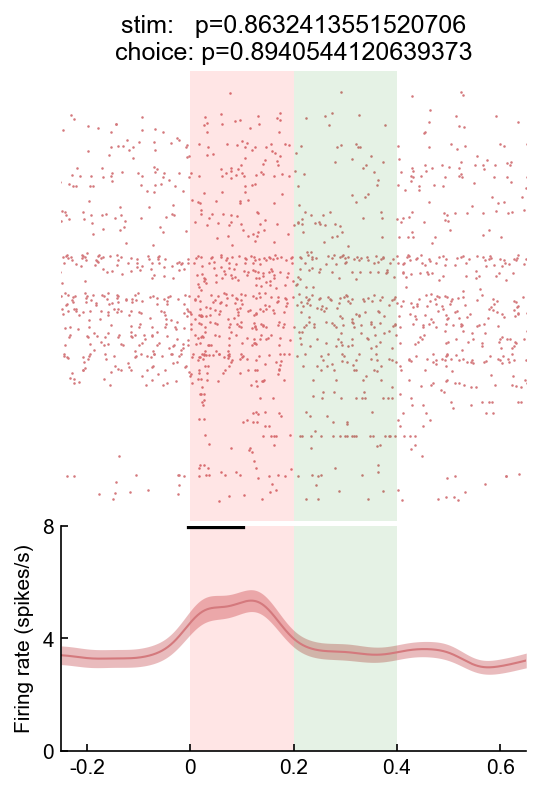

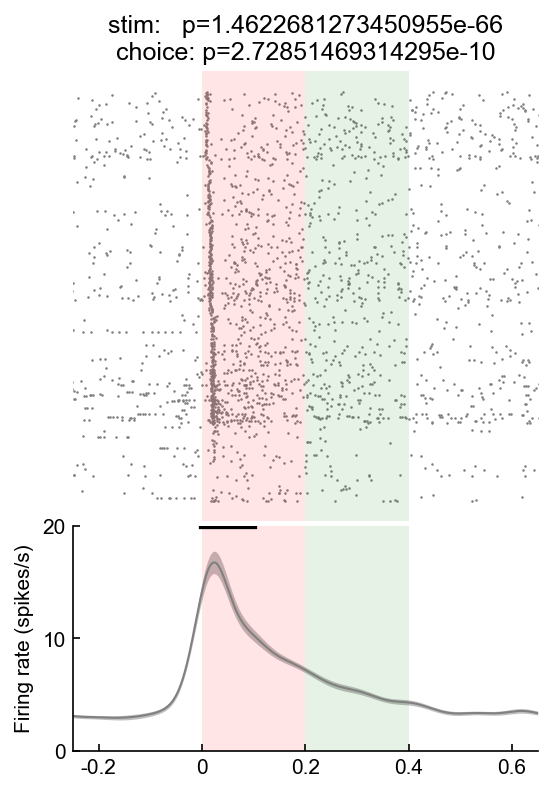

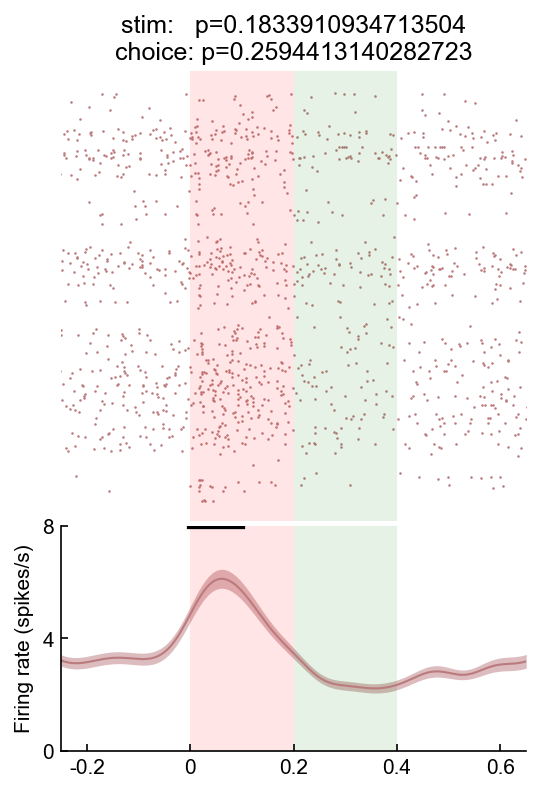

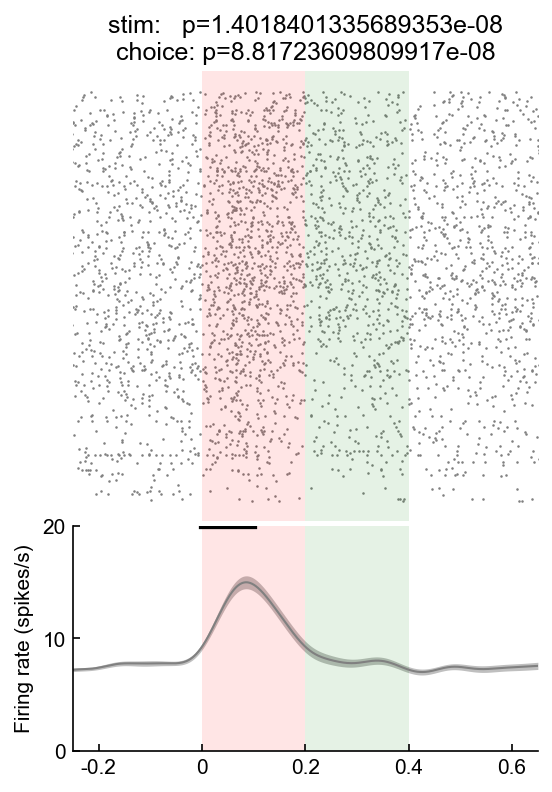

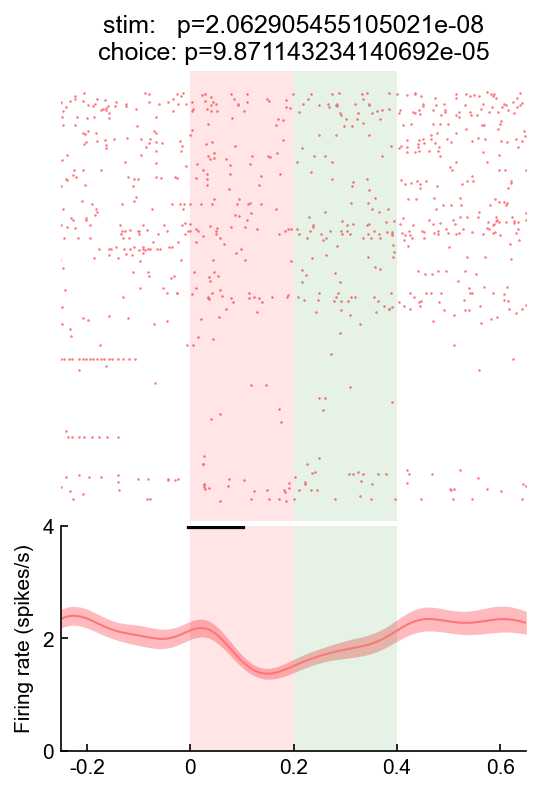

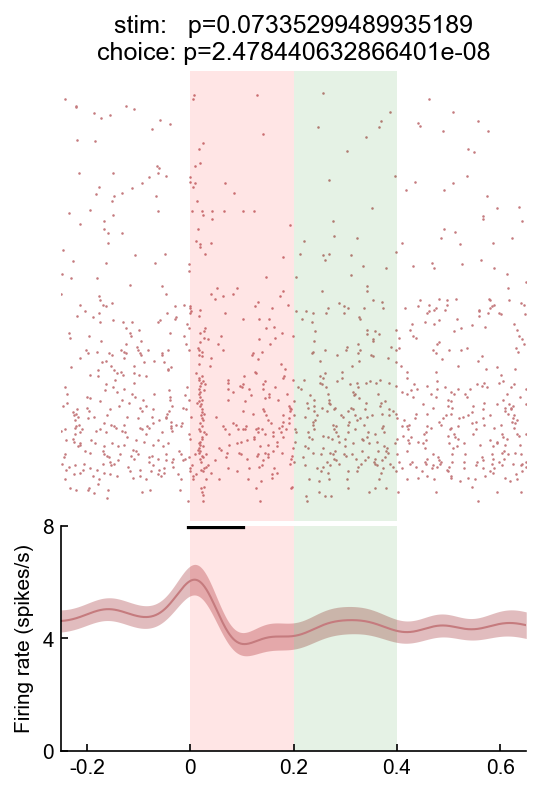

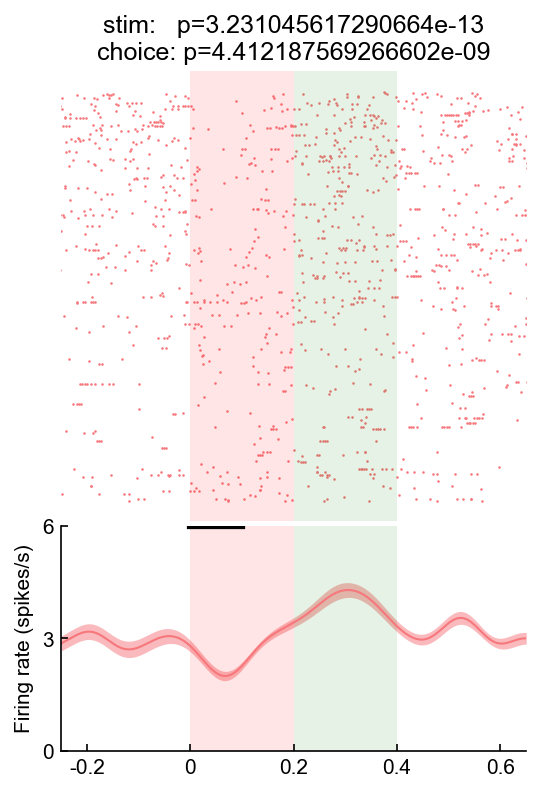

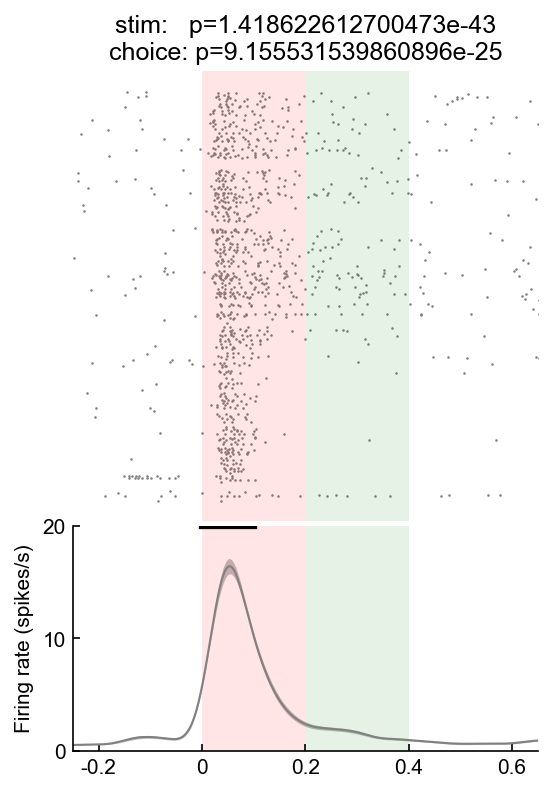

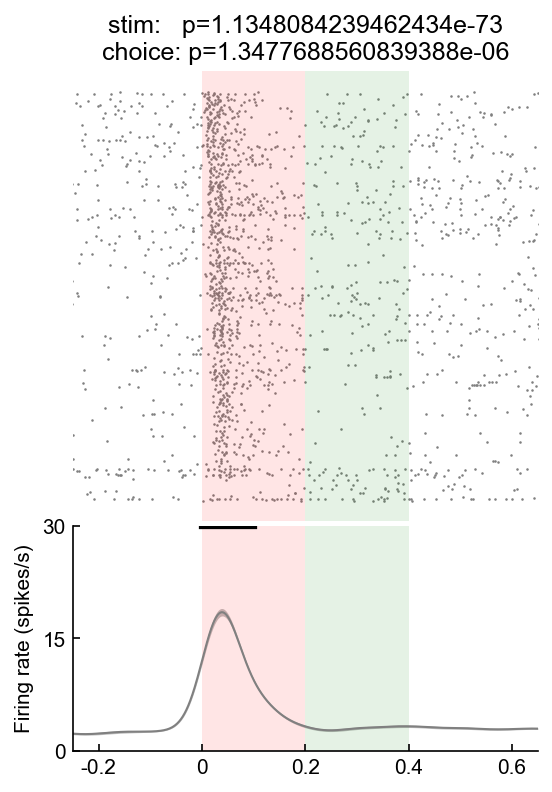

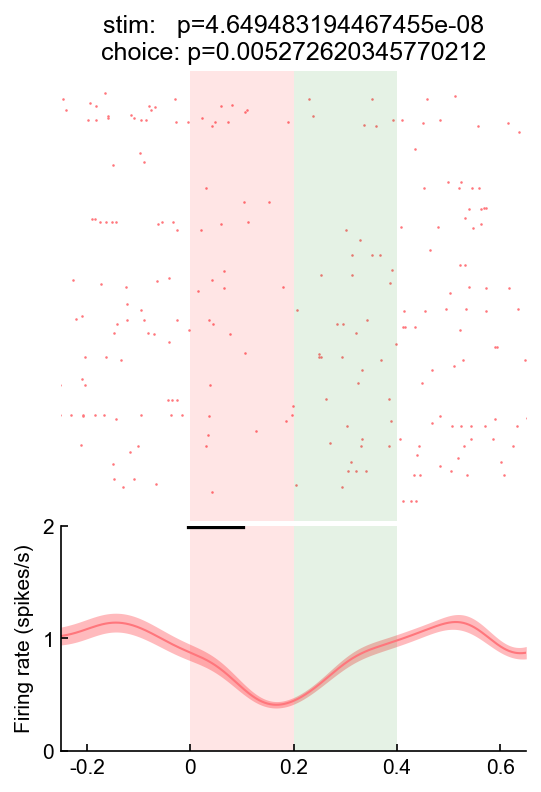

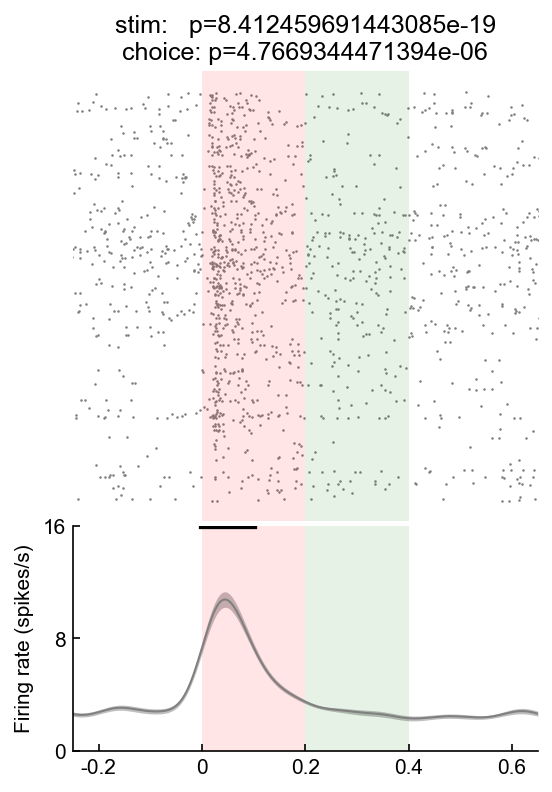

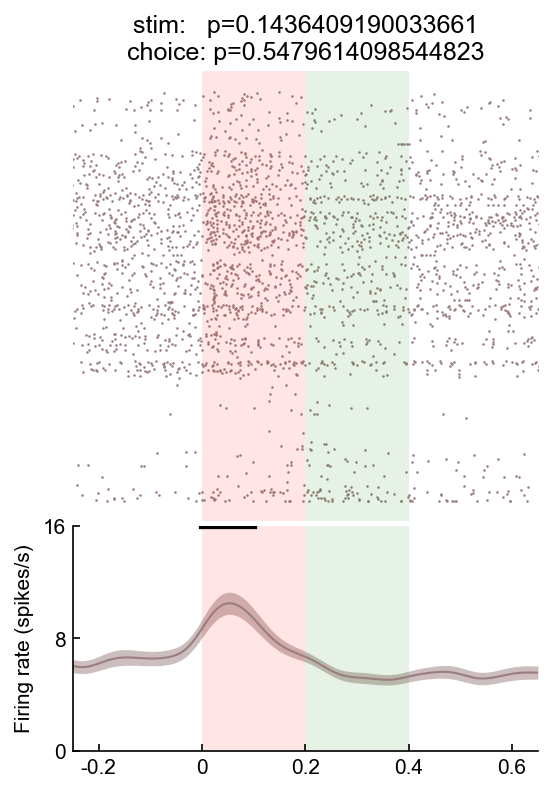

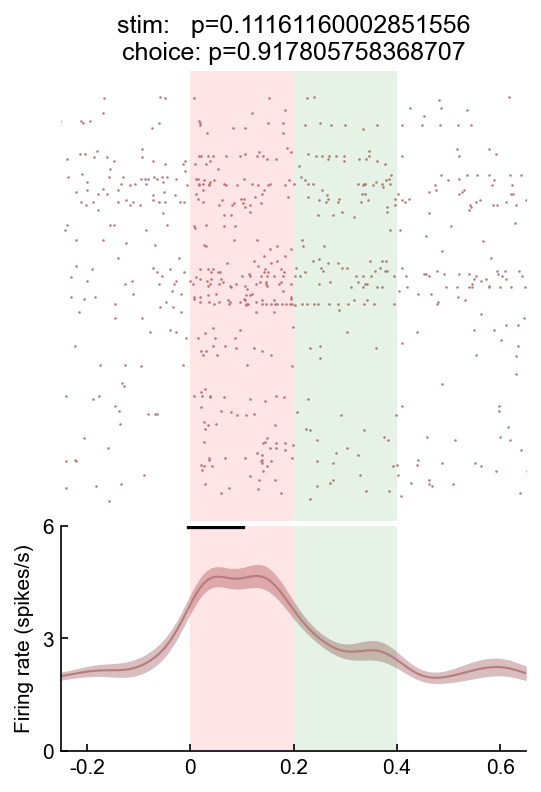

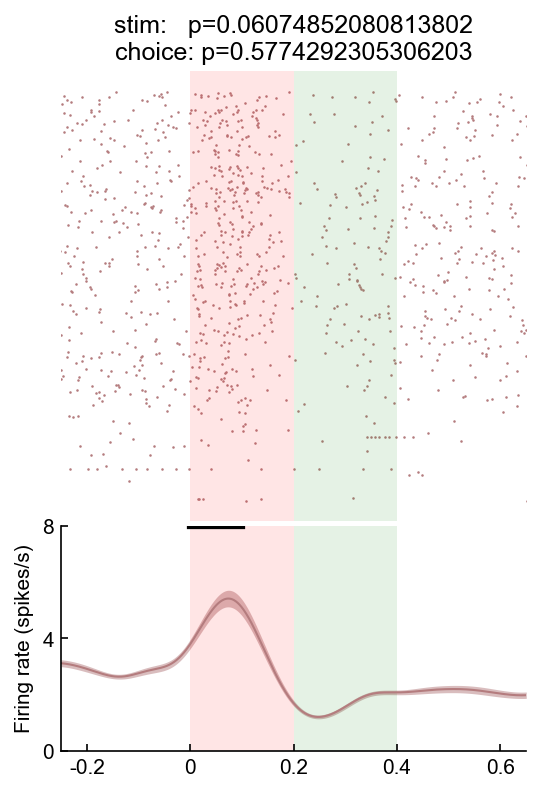

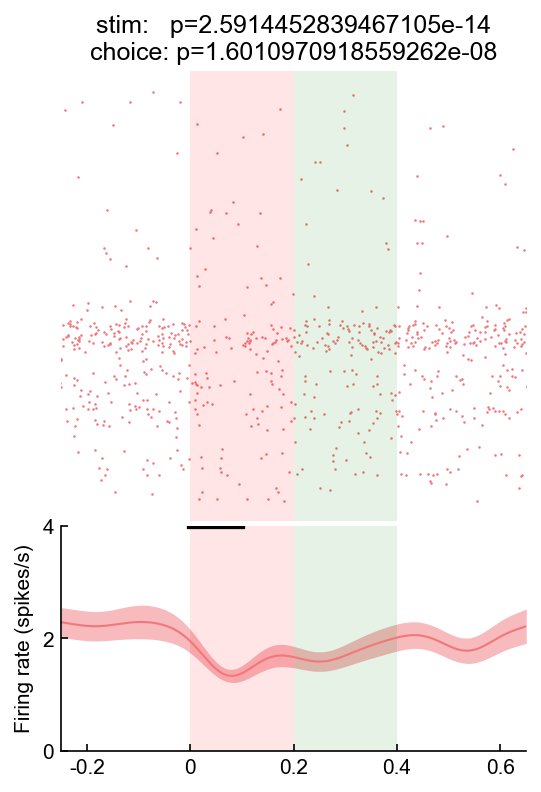

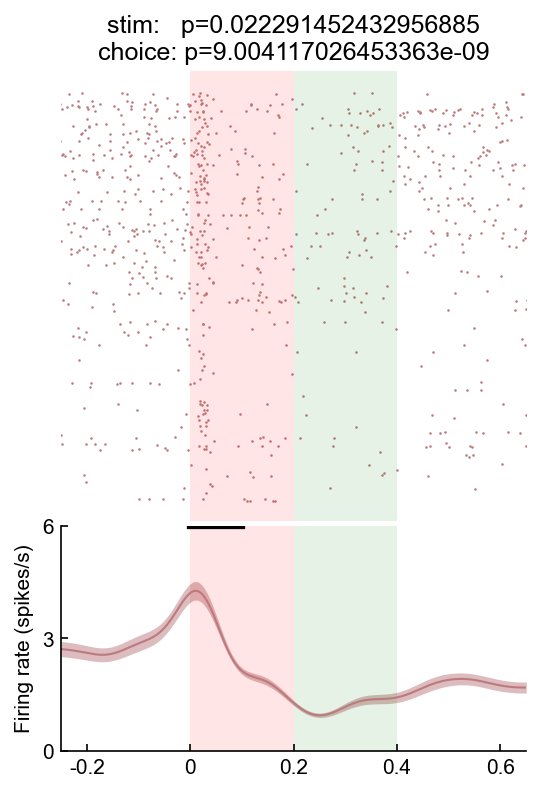

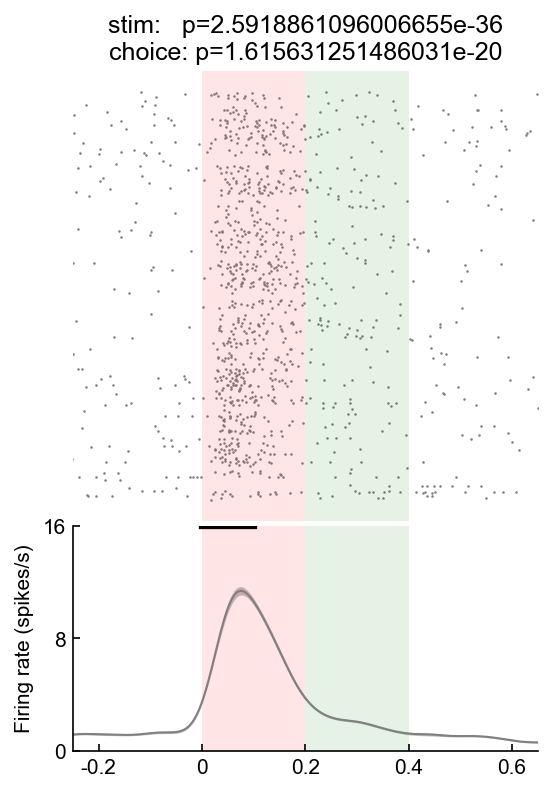

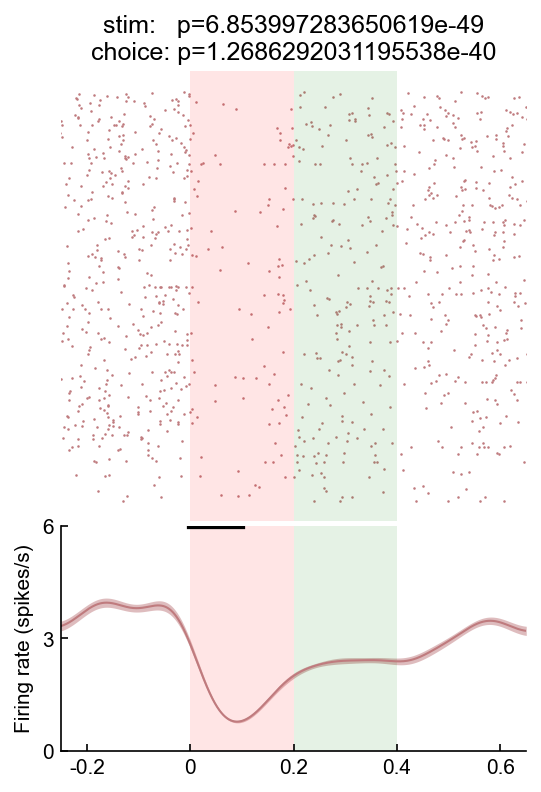

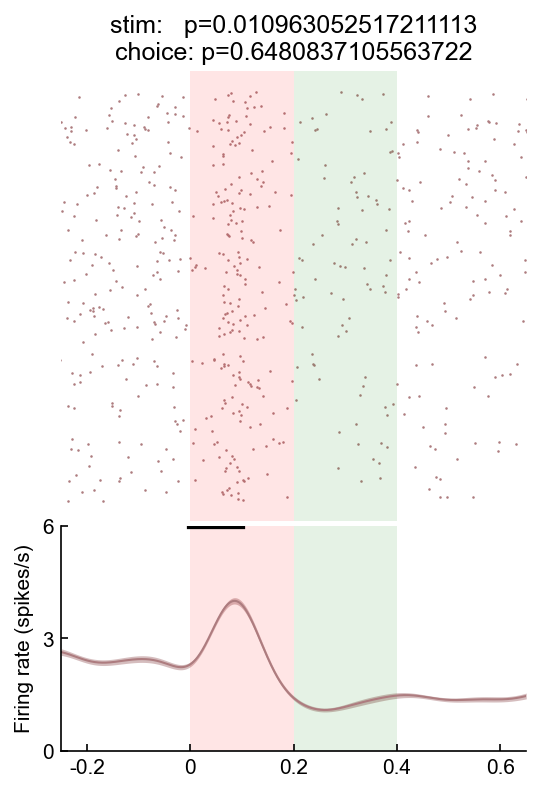

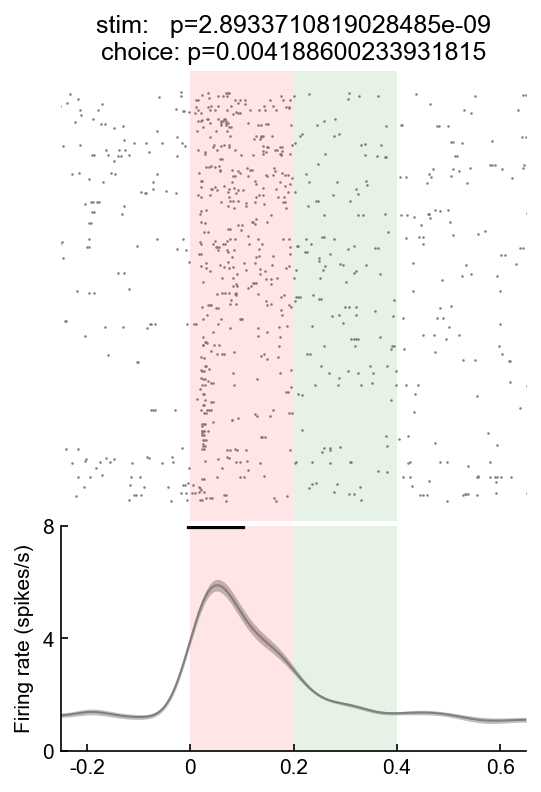

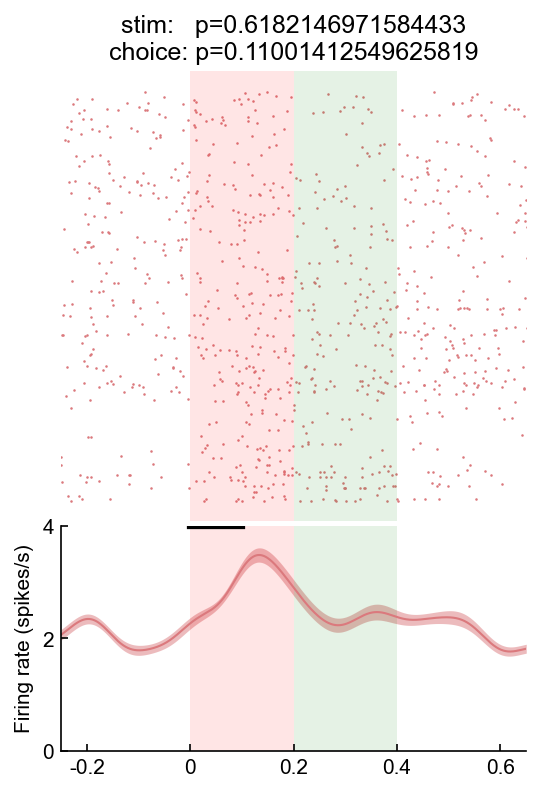

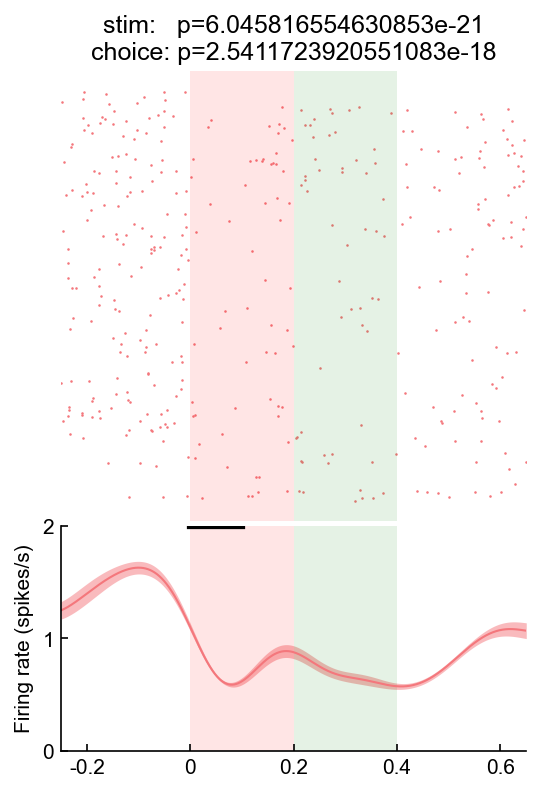

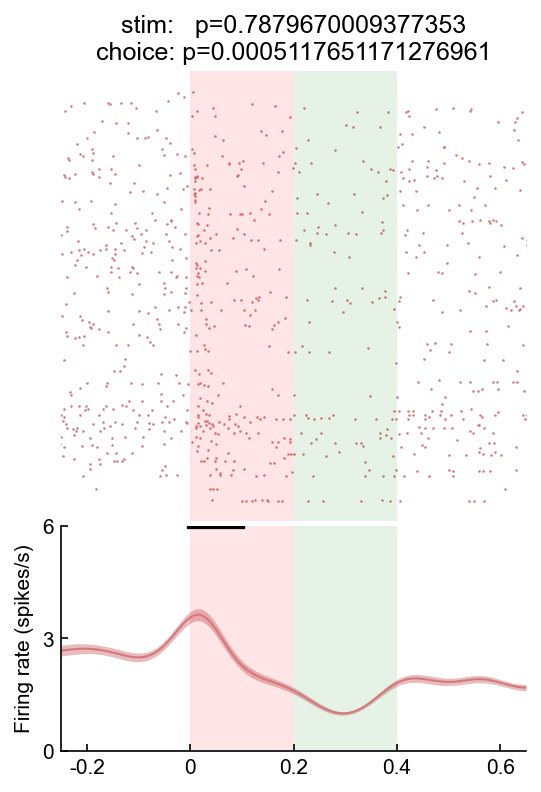

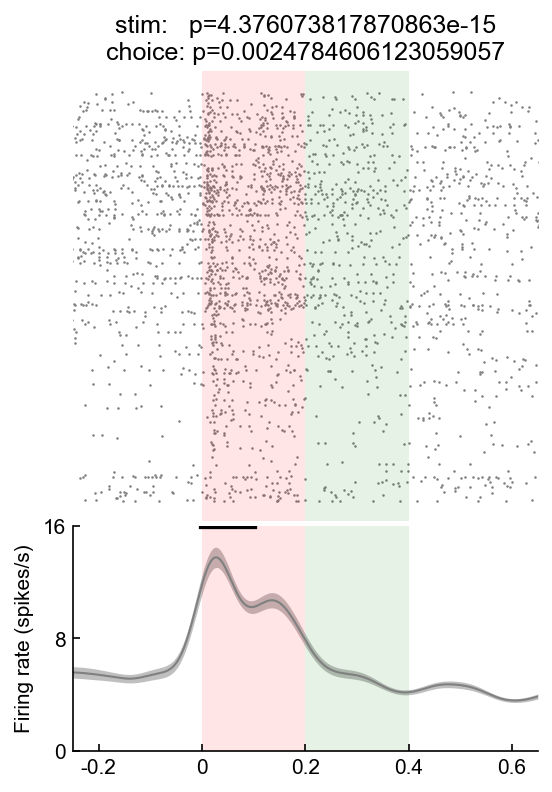

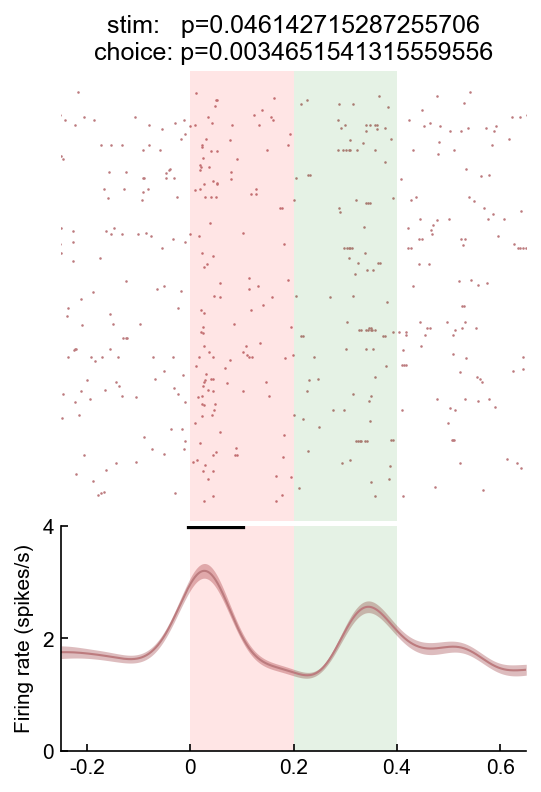

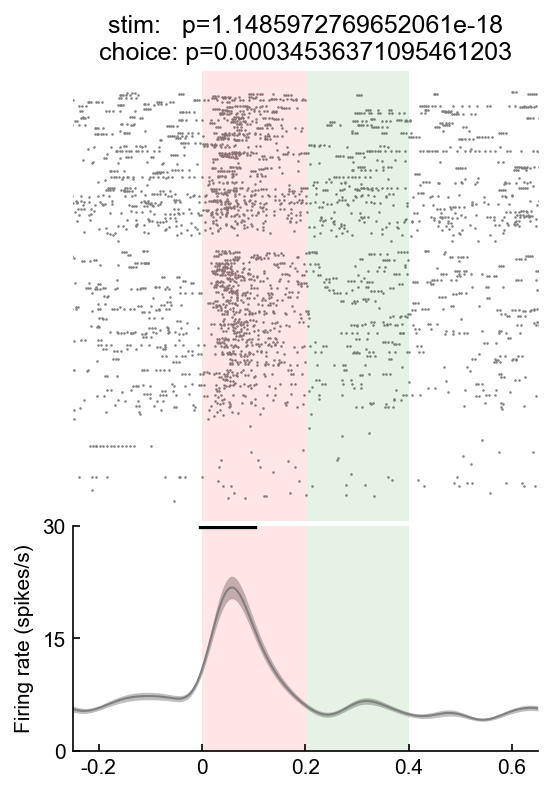

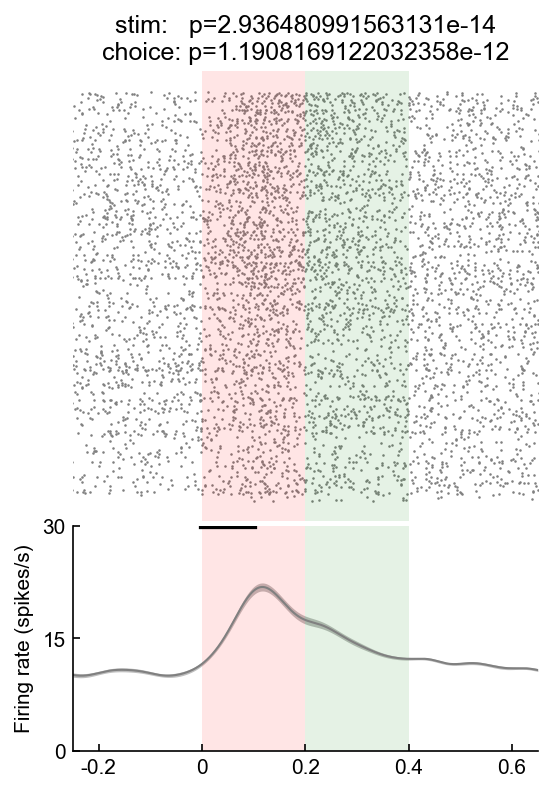

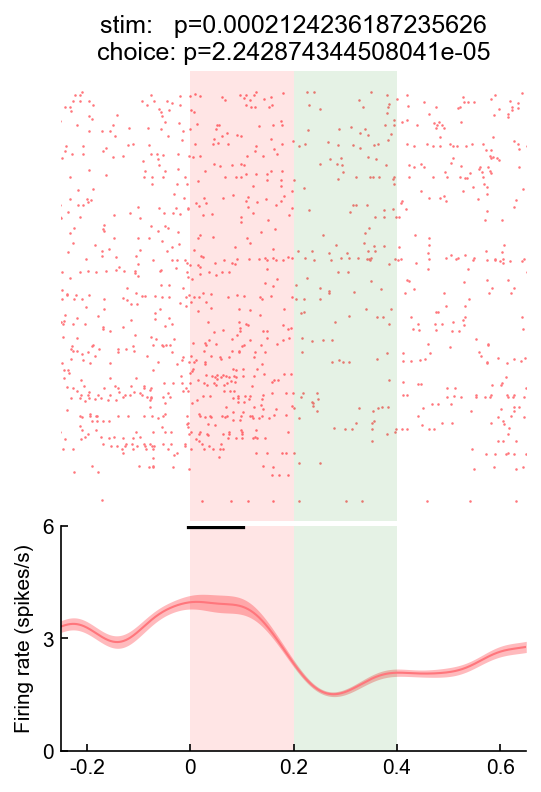

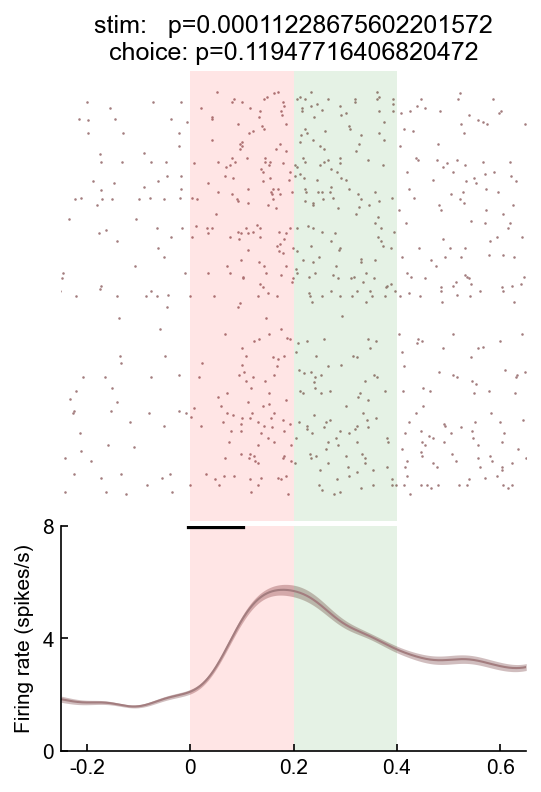

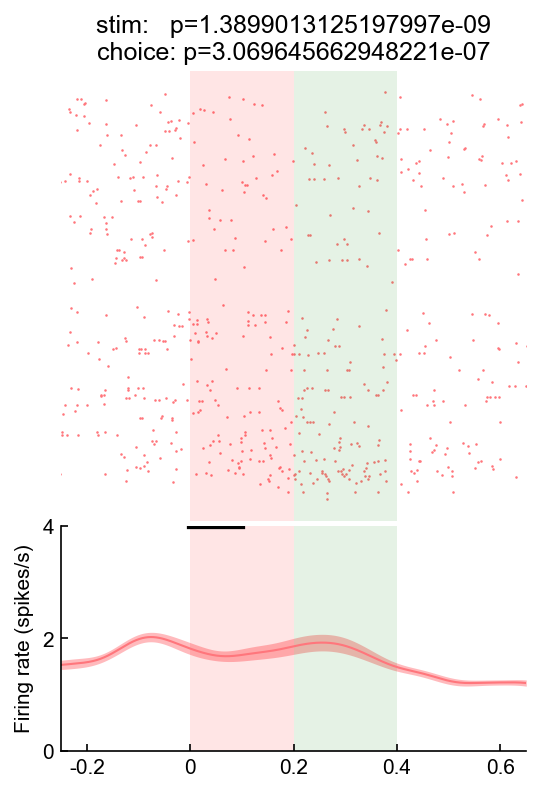

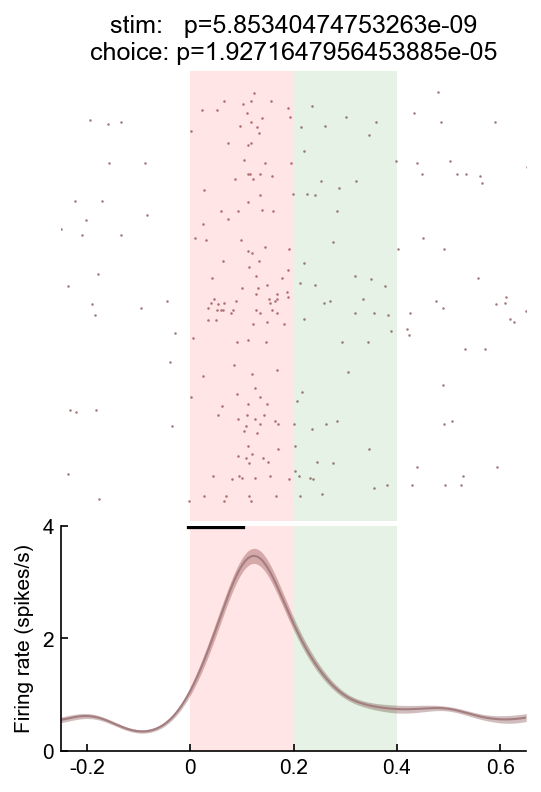

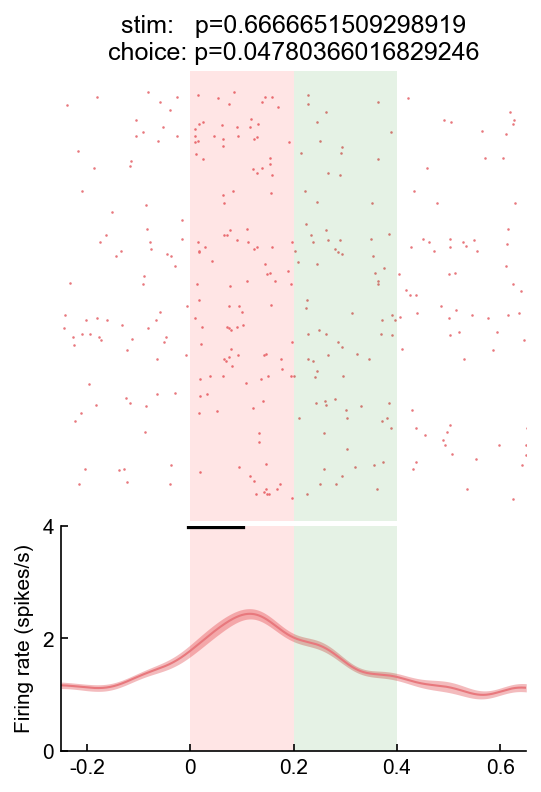

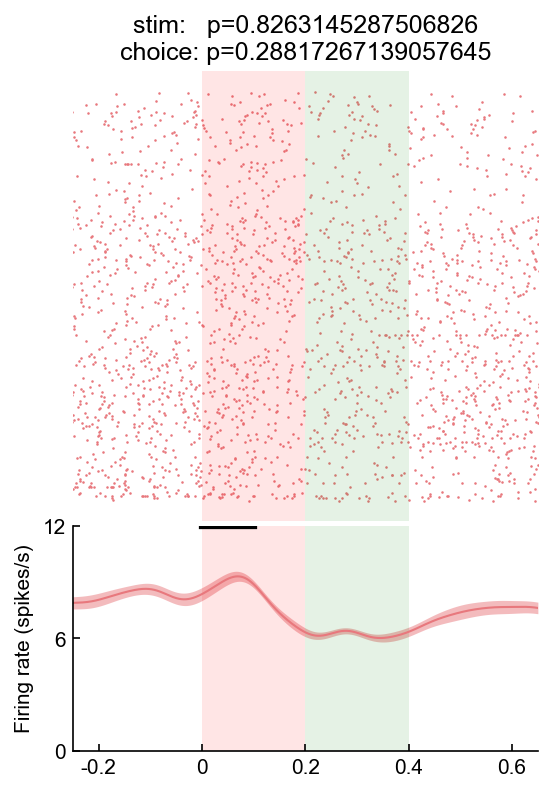

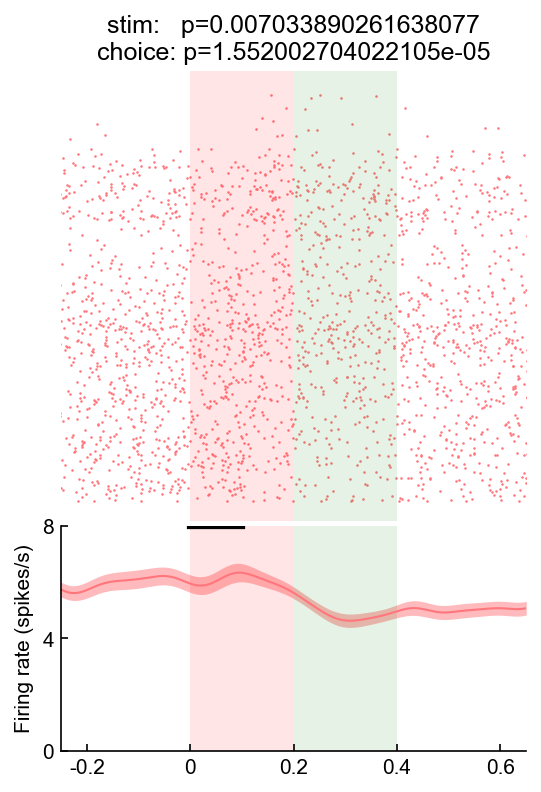

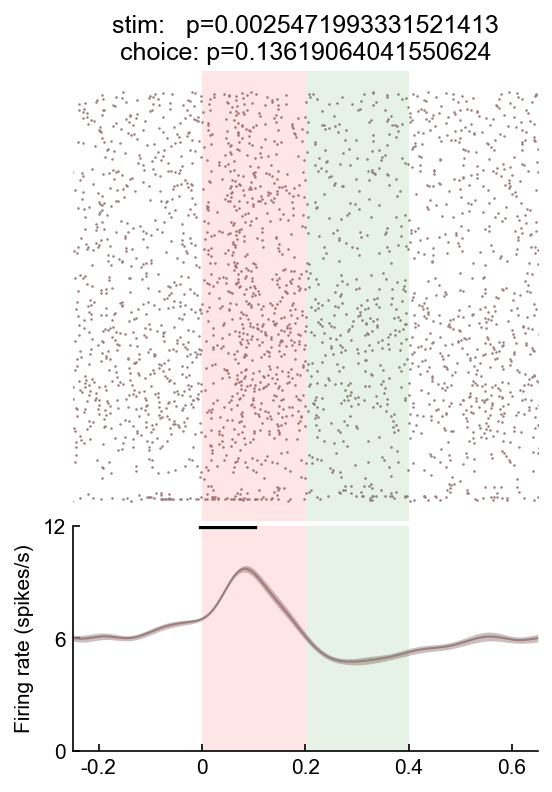

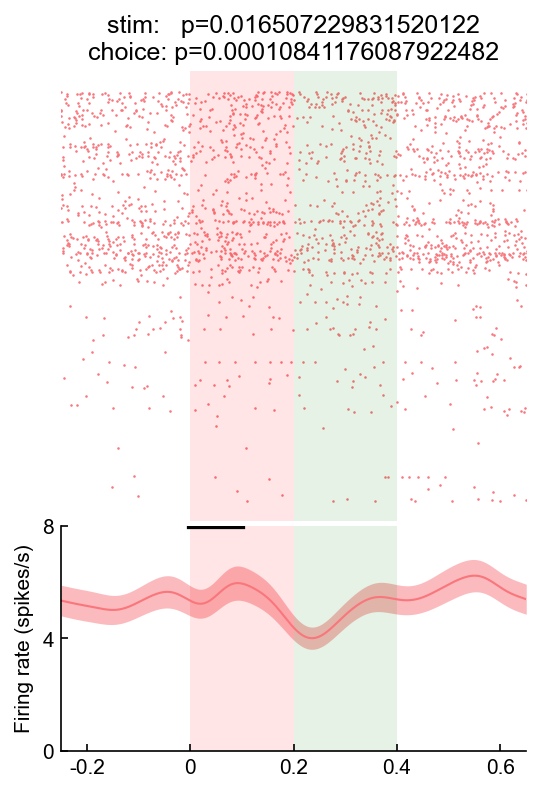

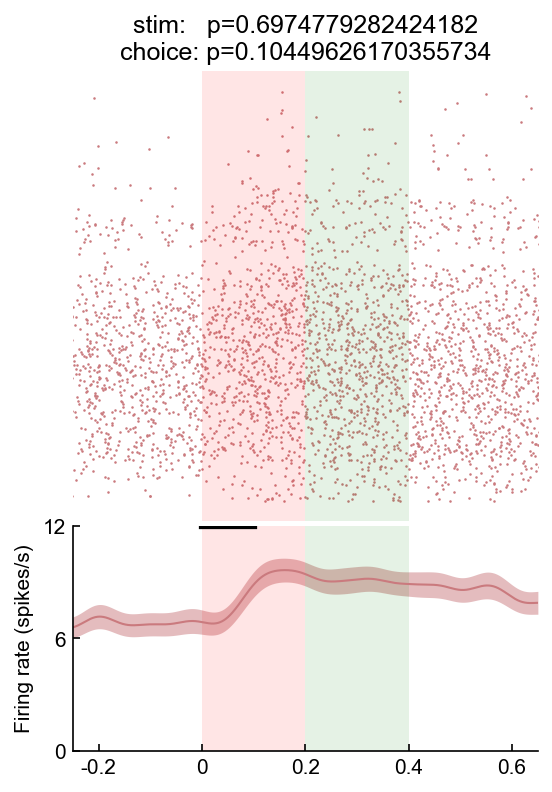

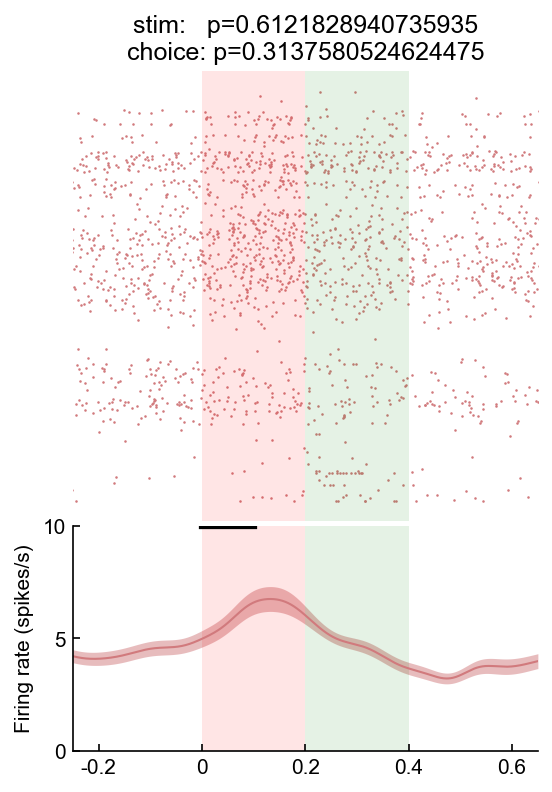

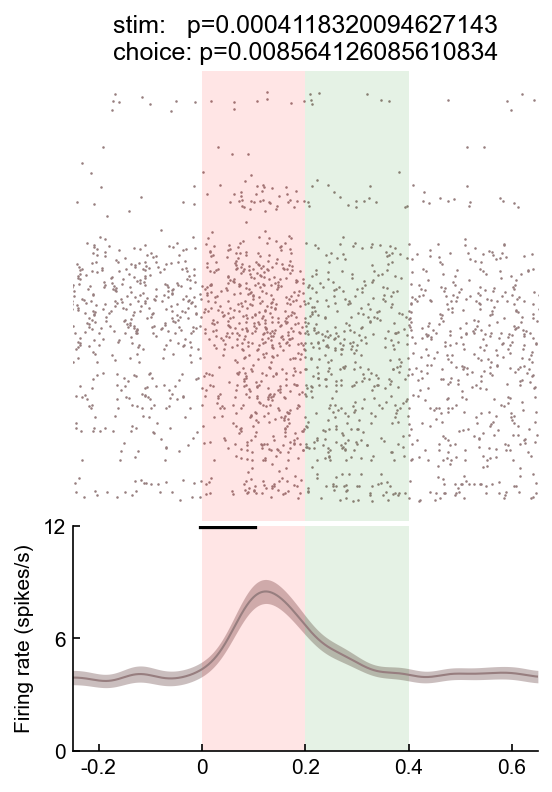

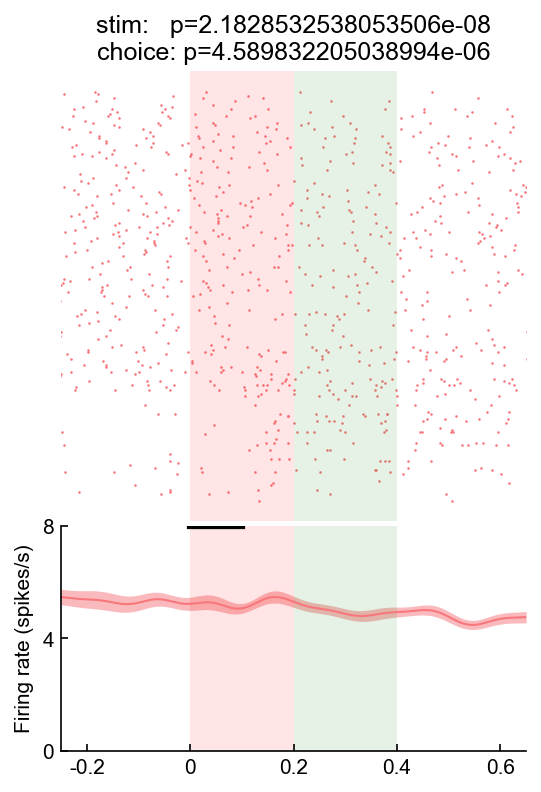

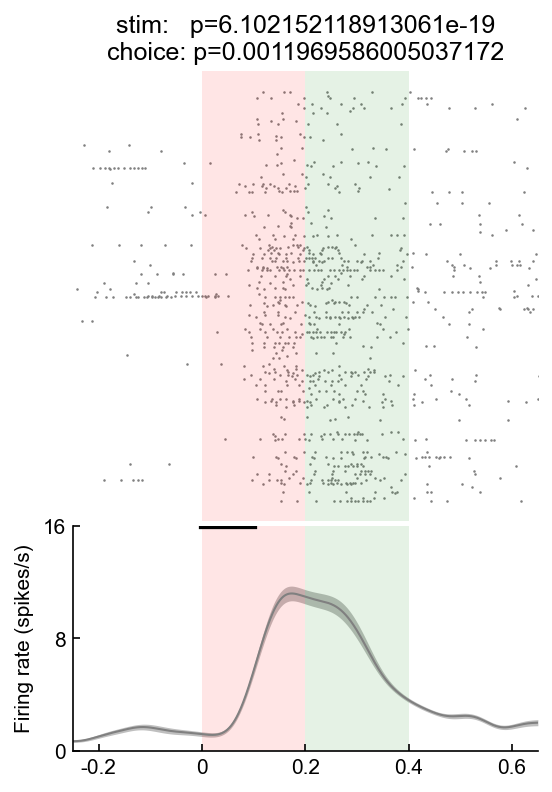

In [50]:
starttime = -250
endtime = 400+250
bw_scott_factor = 3

buffer = 500
bufferedstart = starttime - buffer
bufferedend = endtime + buffer
startbuffer = (0-bufferedstart)/1000
endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

# EnumSession = []
# EnumClust = []
# sessions = os.listdir(act_directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(act_directory,session)
#     for clust in sessionfile.clusters.good:
#         EnumSession.append(session)
#         EnumClust.append(clust)
        
#EnumSession = EnumSession[0:2]
#EnumClust = EnumClust[0:2]
    
session = None
for idx,(this_session,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    
    #if idx == 10:
    #    break
    
    #plt.close('all')
    if this_session != session:
        session = this_session
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
    #########################################################################################
        
    region = sessionfile.meta.region
        
    #########################################################################################
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    
    trialsToPlot = sessionfile.trim[clust].trimmed_trials
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax1.set_xlim([starttime,endtime])
        
    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)
    
    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    
    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)
    
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-200,0,200,400,600])
    ax2.set_xticklabels(['-0.2','0','0.2','0.4','0.6'])
    #ax2.set_xlabel('Time (s)')
    
    pval_stim = sessionfile.responsiveness[clust]['all_trials'].FRmodpval
    pval_choice = sessionfile.responsiveness[clust]['all_trials'].FRmodpvalchoice
    ax1.set_title('stim:   p='+str(pval_stim)+'\nchoice: p='+str(pval_choice))
    
    ylims1 = ax1.get_ylim()
    ax1.fill_between([0,200],ylims1[0]*2,ylims1[1]*2,color='red',lw=0,alpha=0.1)
    ax1.fill_between([200,400],ylims1[0]*2,ylims1[1]*2,color='green',lw=0,alpha=0.1)
    ax1.set_ylim(ylims1)
    ylims2 = ax2.get_ylim()
    ax2.fill_between([0,200],ylims2[0]*2,ylims2[1]*2,color='red',lw=0,alpha=0.1)
    ax2.fill_between([200,400],ylims2[0]*2,ylims2[1]*2,color='green',lw=0,alpha=0.1)
    ax2.set_ylim(ylims2)
    
    fig.savefig(os.path.join('D:\\\\TempFigures','StimChoice Rasters',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")

In [5]:
def visualizeCluster(sessionfile,clust):

    starttime = -250
    endtime = 1500
    bw_scott_factor = 3

    buffer = 500
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot = sessionfile.trim[clust].trimmed_trials
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)

    if sessionfile.meta.task == 'switch':
        try:
            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
        except:
            pass

    #Plot PSTH
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')

In [2]:
session = os.listdir(act_directory)
session = np.random.permutation(session)
session = session[0]
sessionfile = ilep.loadSessionCached(act_directory,session)

clust = sessionfile.clusters.good
clust = clust[0]

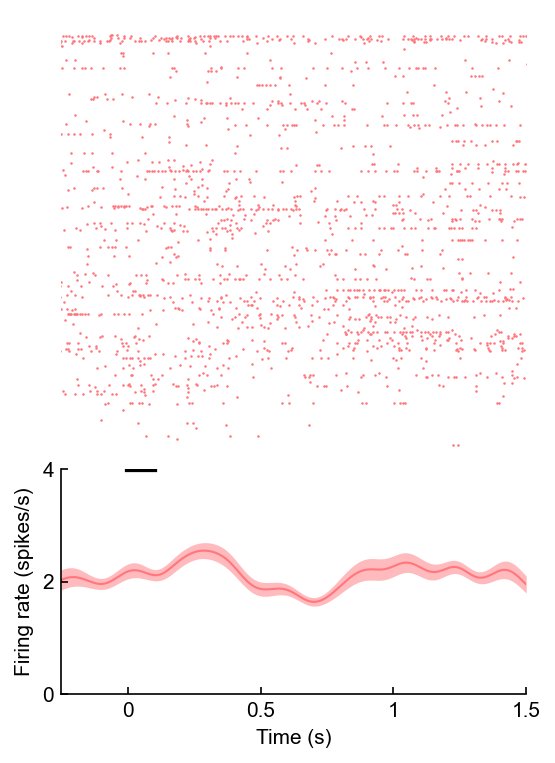

In [3]:
ilep.visualizeCluster(sessionfile,clust)

In [4]:
def visualizeClusterTuning(sessionfile,clust):

    #Tone presentations are 1.4s apart.
    #I will treat this as a 1s trial with a 0.4s ITI
    
    starttime = -250
    endtime = 1000
    bw_scott_factor = 3

    buffer = 500
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-1000)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    #FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    #FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    FRmod_color = 'k'
    
    
    
    trialsToPlot = range(len(sessionfile.tuning.trial_starts))
    #trialsToPlot = sessionfile.trim[clust].trimmed_trials
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    for trial in trialsToPlot:
        #this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialstart = sessionfile.tuning.trial_starts[trial]#samples
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,cachedtimes=clustSpikes,starttime=trialstart-0.5*sessionfile.meta.fs,endtime=trialstart+1.25*sessionfile.meta.fs)
        #Put in ms
        this_trial_spikes = this_trial_spikes - trialstart
        this_trial_spikes = this_trial_spikes / sessionfile.meta.fs * 1000
        trialSpikes.append(this_trial_spikes)
    trialSpikes = np.array(trialSpikes,dtype='object')
    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)

    if sessionfile.meta.task == 'switch':
        try:
            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
        except:
            pass
        

        
    #Plot PSTH
    #PSTHstart = starttime - 0.25
    #PSTHend = endtime + 0.25
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-250,0,250,500,750,1000])
    ax2.set_xticklabels(['-0.25','0','0.25','0.5','0.75','1'])
    ax2.set_xlabel('Time (s)')
    
    return fig

In [2]:
EnumSession = []
EnumClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
        
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
    for clust in sessionfile.clusters.good:
        if sessionfile.tuning.number_of_tones > 0 and len(sessionfile.trim[clust].trimmed_tuning_trials) / len(np.unique(sessionfile.tuning.trial_freqs)) < 30:
            continue
        #print(len(sessionfile.trim[clust].trimmed_tuning_trials) / len(np.unique(sessionfile.tuning.trial_freqs)))
        #print(sessionfile.meta.length_in_seconds - sessionfile.trim[clust].trimmed_end_in_seconds)
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 471/471 [00:01<00:00, 309.62it/s]


125it [02:29,  4.49it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


130it [02:29,  7.40it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


140it [02:29, 14.78it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


191it [03:24,  4.24it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


196it [03:24,  6.92it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


205it [03:24, 12.96it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


215it [03:26,  7.42it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


225it [03:27, 13.23it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


230it [03:27, 16.78it/s]

Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.


537it [11:02,  1.23s/it]


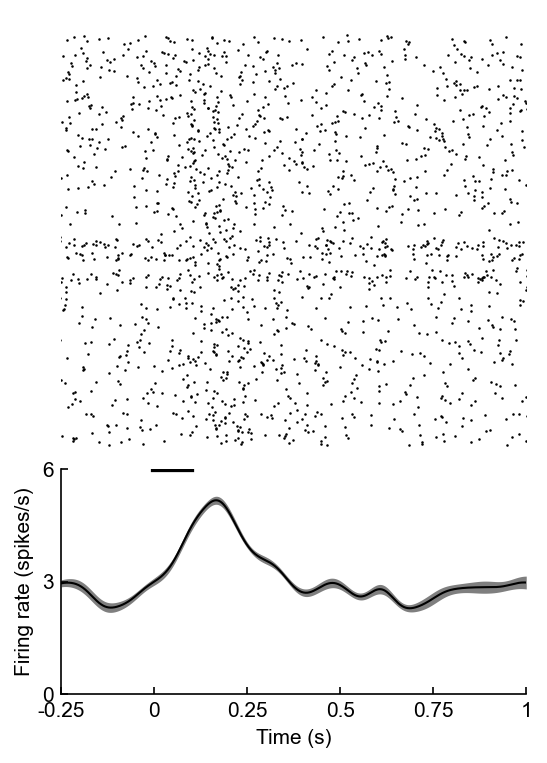

In [5]:
for session,clust in tqdm(zip(EnumSession,EnumClust)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    plt.close('all')
    try:
        fig = visualizeClusterTuning(sessionfile,clust)
        fig.savefig(os.path.join('D:\\\\TempFigures','Tuning Rasters',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    except Exception as e:
        print(e)

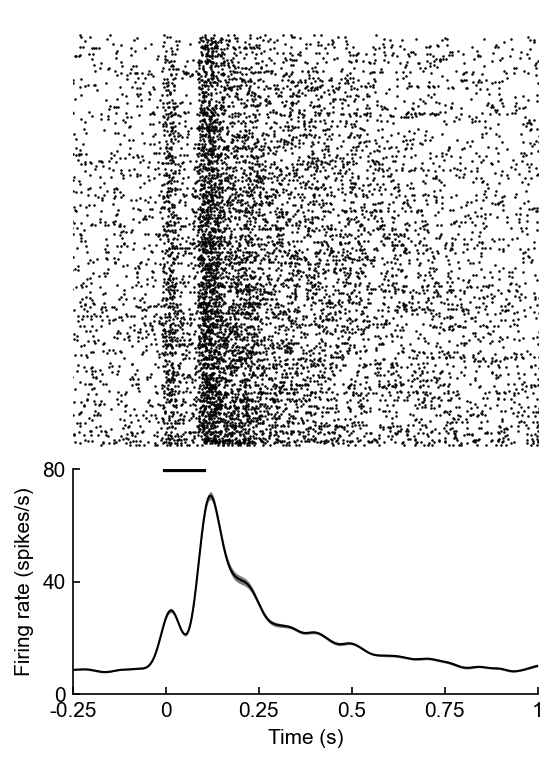

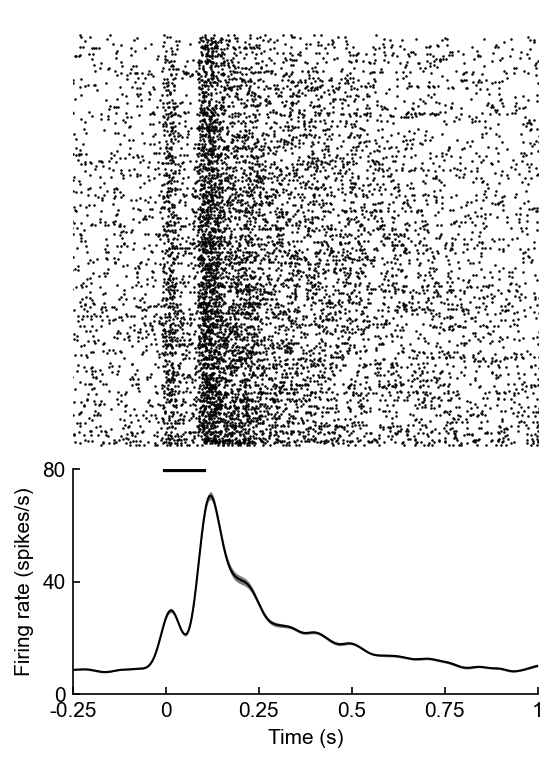

In [65]:
session = EnumSession[0]
sessionfile = ilep.loadSessionCached(act_directory,session)
clust = EnumClust[0]
visualizeClusterTuning(sessionfile,clust)